In [1]:
import os
import sys
sys.path.append("/Users/marioauditore/Desktop/Skoltech/NLA/Project MARS/main")

from tqdm import tqdm

from mars import MARS, get_MARS_attr, set_MARS_attr
from tensorized_models import TTLinear, TTConv2d, TuckerConv2d, FactorizedLinear

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils
import torch.distributions
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device = "cpu"
device

'cpu'

Below we write the `Encoder` class by sublcassing `torch.nn.Module`, which lets us define the `__init__` method storing layers as an attribute, and a `forward` method describing the forward pass of the network.

In [3]:
# Compression modes parameters
modes_dict = {
    "soft": dict(pi=1e-1, alpha=-1.5),
    "hard": dict(pi=1e-2, alpha=-1.75),
    "tough": dict(pi=1e-2, alpha=-1.75)
}

In [4]:
class FactorizedVariationalEncoder(nn.Module):
    def __init__(self, latent_dims, pi, alpha):
        super(FactorizedVariationalEncoder, self).__init__()
        self.linear1 = MARS(
            FactorizedLinear(784, 512, rank=100),
            pi=pi,
            alpha=alpha
        )
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [5]:
class TTDecoder(nn.Module):
    def __init__(self, latent_dims, pi, alpha):
        super(TTDecoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = MARS(
            TTLinear(
                512, 
                784, 
                d=4, 
                tt_rank=20, 
                auto_shapes=True
            ),
            pi=pi,
            alpha=alpha
        )
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))


class FactorizedDecoder(nn.Module):
    def __init__(self, latent_dims, pi, alpha):
        super(FactorizedDecoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = MARS(
            FactorizedLinear(512, 784, rank=100),
            pi=pi,
            alpha=alpha
        )
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

The autoencoder class changes a single line of code, swappig out an `Encoder` for a `VariationalEncoder`. 

In [6]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, pi, alpha):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = FactorizedVariationalEncoder(latent_dims, pi, alpha)
        self.decoder = FactorizedDecoder(latent_dims, pi, alpha)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [7]:
# Modification of MARS class

def compute_cum_reg(model):
    "Compute the cumulative MARS regularizer term of the model."
    reg = 0.0
    
    for layer in model.modules():
        if isinstance(layer, MARS):
            reg += layer.compute_reg()
            
    return reg
    
class MARSLoss(nn.Module):
    def __init__(self, model, train_size, criterion=None, reg_term_coef=1.0):
        """
        MARS regularized loss.

        Parameters are:
        model : MARS
            The tensorized MARS model.
        train_size : int
            The number of training samples.
        criterion : nn.Module
            The criterion calculating log-likelihood.
        reg_term_coef : float
            Regularizer term multiplicative coefficient.
        """
        super().__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss() if criterion is None else criterion
        self.reg_term_coef = reg_term_coef / train_size  # regularization term coefficient
        
    def forward(self, output, target, *args):
        neg_data_term = self.criterion(output, target, *args)
        reg_term = compute_cum_reg(self.model)
        return neg_data_term - self.reg_term_coef * reg_term

In [8]:
def train_mars(model_idx, latent_dims, mode="soft", save=True, load=True):
    """
    Train the model or load the trained one.
    
    Parameters are:
        model_idx : int
            Model index to load or save.
        mode : str in {'soft', 'hard'}
            Compression mode.
        save : bool
            Whether to save the trained model.
        load : bool
            Whether to load the trained model.
    """
    model_directory_path = f"./models/VAE/{mode}/"
    prefix = str(model_idx)
        
    model_path = model_directory_path + prefix + '-model.pt'
    losses_path = model_directory_path + prefix + '-losses.npy'
    print("Model path: ", model_path)

    if save and not os.path.exists(model_directory_path):
        os.makedirs(model_directory_path)
        
    model = VariationalAutoencoder(latent_dims, **modes_dict[mode]).to(device)
    
    if load and os.path.isfile(model_path):
        # load trained model parameters from disk
        model.load_state_dict(torch.load(model_path))
        losses = np.load(losses_path)
        print('Loaded model parameters from disk.')
        return model, losses
    
    model_criterion = lambda x, x_hat, autoencoder: ((x - x_hat)**2).sum() + autoencoder.encoder.kl
    criterion = MARSLoss(model, len(data), model_criterion)
    
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

    print("Training...")
    model.train()
    losses = []
    log_step = len(data) // 300 * 100
    
    for epoch in tqdm(range(n_epochs)):
        running_loss = 0.0
        running_cel = 0.0
        losses.append(0.0)

        for i, (inputs, labels) in enumerate(data, 0):
            # get the inputs
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, inputs, model)
            losses[-1] += loss.item()
            loss.backward()
            optimizer.step()

            # update statistics
            running_loss += loss.item()
            # with torch.no_grad():
            #     cel = cross_entropy(outputs, labels)
            # running_cel += cel.item()

            if i % log_step == log_step-1:
                print('[%d, %5d] \t Loss: %.3f \t T: %.3f' %
                      (epoch + 1, i + 1, 
                       running_loss / log_step, 
                       # running_cel / log_step, 
                       get_MARS_attr(model, "temperature")))
                running_loss = 0.0
                running_cel = 0.0
                
        losses[-1] /= i + 1
        
        new_temp = temp_anneal(get_MARS_attr(model, "temperature"))
        set_MARS_attr(model, "temperature", new_temp)

        scheduler.step()

    losses = np.array(losses)
    print('Finished Training.')
    
    if save:
        torch.save(model.state_dict(), model_path)
        np.save(losses_path, losses)
        print('Saved model parameters to disk.')
    
    return model, losses

In [9]:
latent_dims = 2

n_epochs = 300  
batch_size = 128
lr = 1e-3
gamma = 0.99
temp_anneal = lambda t: max(1e-2, gamma * t)

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=batch_size,
        shuffle=True)

n_models = 1  # set the number of models in ensemble
mode = "hard"  # set the compression mode
models, losses = [], []

In [10]:
for k in range(1, n_models + 1):
    print(f"Model number {k}...")
    # model = Autoencoder(latent_dims, **modes_dict[mode])
    
    model, loss = train_mars(k, latent_dims, mode, load=False)
    
    losses.append(loss)
    models.append(model)
    
    print()
    print(100*'=')
    print()

Model number 1...
Model path:  ./models/VAE/hard/1-model.pt
Training...


  0%|                                                   | 0/300 [00:00<?, ?it/s]

[1,   100] 	 Loss: 15214.112 	 T: 0.100
[1,   200] 	 Loss: 8330.112 	 T: 0.100
[1,   300] 	 Loss: 7692.254 	 T: 0.100
[1,   400] 	 Loss: 7508.216 	 T: 0.100


  0%|▏                                          | 1/300 [00:03<15:18,  3.07s/it]

[2,   100] 	 Loss: 7171.464 	 T: 0.099
[2,   200] 	 Loss: 7091.861 	 T: 0.099
[2,   300] 	 Loss: 7012.904 	 T: 0.099
[2,   400] 	 Loss: 6935.108 	 T: 0.099


  1%|▎                                          | 2/300 [00:06<15:19,  3.09s/it]

[3,   100] 	 Loss: 6825.254 	 T: 0.098
[3,   200] 	 Loss: 6763.241 	 T: 0.098
[3,   300] 	 Loss: 6785.213 	 T: 0.098
[3,   400] 	 Loss: 6764.324 	 T: 0.098


  1%|▍                                          | 3/300 [00:09<15:07,  3.06s/it]

[4,   100] 	 Loss: 6742.932 	 T: 0.097
[4,   200] 	 Loss: 6749.992 	 T: 0.097
[4,   300] 	 Loss: 6634.370 	 T: 0.097
[4,   400] 	 Loss: 6607.353 	 T: 0.097


  1%|▌                                          | 4/300 [00:12<15:00,  3.04s/it]

[5,   100] 	 Loss: 6570.894 	 T: 0.096
[5,   200] 	 Loss: 6634.407 	 T: 0.096
[5,   300] 	 Loss: 6551.614 	 T: 0.096
[5,   400] 	 Loss: 6569.777 	 T: 0.096


  2%|▋                                          | 5/300 [00:15<14:54,  3.03s/it]

[6,   100] 	 Loss: 6558.689 	 T: 0.095
[6,   200] 	 Loss: 6516.671 	 T: 0.095
[6,   300] 	 Loss: 6495.571 	 T: 0.095
[6,   400] 	 Loss: 6508.666 	 T: 0.095


  2%|▊                                          | 6/300 [00:18<14:54,  3.04s/it]

[7,   100] 	 Loss: 6506.481 	 T: 0.094
[7,   200] 	 Loss: 6494.449 	 T: 0.094
[7,   300] 	 Loss: 6493.028 	 T: 0.094
[7,   400] 	 Loss: 6539.605 	 T: 0.094


  2%|█                                          | 7/300 [00:21<14:47,  3.03s/it]

[8,   100] 	 Loss: 6500.605 	 T: 0.093
[8,   200] 	 Loss: 6471.932 	 T: 0.093
[8,   300] 	 Loss: 6451.495 	 T: 0.093
[8,   400] 	 Loss: 6478.299 	 T: 0.093


  3%|█▏                                         | 8/300 [00:24<14:46,  3.04s/it]

[9,   100] 	 Loss: 6492.231 	 T: 0.092
[9,   200] 	 Loss: 6472.015 	 T: 0.092
[9,   300] 	 Loss: 6482.726 	 T: 0.092
[9,   400] 	 Loss: 6470.397 	 T: 0.092


  3%|█▎                                         | 9/300 [00:27<14:51,  3.06s/it]

[10,   100] 	 Loss: 6450.163 	 T: 0.091
[10,   200] 	 Loss: 6424.062 	 T: 0.091
[10,   300] 	 Loss: 6407.127 	 T: 0.091
[10,   400] 	 Loss: 6430.748 	 T: 0.091


  3%|█▍                                        | 10/300 [00:30<14:54,  3.08s/it]

[11,   100] 	 Loss: 6385.794 	 T: 0.090
[11,   200] 	 Loss: 6390.563 	 T: 0.090
[11,   300] 	 Loss: 6410.711 	 T: 0.090
[11,   400] 	 Loss: 6409.654 	 T: 0.090


  4%|█▌                                        | 11/300 [00:33<14:54,  3.09s/it]

[12,   100] 	 Loss: 6410.404 	 T: 0.090
[12,   200] 	 Loss: 6418.650 	 T: 0.090
[12,   300] 	 Loss: 6429.288 	 T: 0.090
[12,   400] 	 Loss: 6377.559 	 T: 0.090


  4%|█▋                                        | 12/300 [00:36<14:55,  3.11s/it]

[13,   100] 	 Loss: 6399.572 	 T: 0.089
[13,   200] 	 Loss: 6357.754 	 T: 0.089
[13,   300] 	 Loss: 6382.853 	 T: 0.089
[13,   400] 	 Loss: 6394.744 	 T: 0.089


  4%|█▊                                        | 13/300 [00:40<14:57,  3.13s/it]

[14,   100] 	 Loss: 6401.969 	 T: 0.088
[14,   200] 	 Loss: 6341.381 	 T: 0.088
[14,   300] 	 Loss: 6393.685 	 T: 0.088
[14,   400] 	 Loss: 6371.798 	 T: 0.088


  5%|█▉                                        | 14/300 [00:43<14:53,  3.13s/it]

[15,   100] 	 Loss: 6339.609 	 T: 0.087
[15,   200] 	 Loss: 6370.126 	 T: 0.087
[15,   300] 	 Loss: 6355.392 	 T: 0.087
[15,   400] 	 Loss: 6363.416 	 T: 0.087


  5%|██                                        | 15/300 [00:46<14:51,  3.13s/it]

[16,   100] 	 Loss: 6343.279 	 T: 0.086
[16,   200] 	 Loss: 6345.901 	 T: 0.086
[16,   300] 	 Loss: 6344.069 	 T: 0.086
[16,   400] 	 Loss: 6342.297 	 T: 0.086


  5%|██▏                                       | 16/300 [00:49<14:49,  3.13s/it]

[17,   100] 	 Loss: 6322.304 	 T: 0.085
[17,   200] 	 Loss: 6357.108 	 T: 0.085
[17,   300] 	 Loss: 6321.676 	 T: 0.085
[17,   400] 	 Loss: 6323.690 	 T: 0.085


  6%|██▍                                       | 17/300 [00:52<14:45,  3.13s/it]

[18,   100] 	 Loss: 6332.185 	 T: 0.084
[18,   200] 	 Loss: 6315.462 	 T: 0.084
[18,   300] 	 Loss: 6356.042 	 T: 0.084
[18,   400] 	 Loss: 6321.772 	 T: 0.084


  6%|██▌                                       | 18/300 [00:56<15:24,  3.28s/it]

[19,   100] 	 Loss: 6298.079 	 T: 0.083
[19,   200] 	 Loss: 6314.420 	 T: 0.083
[19,   300] 	 Loss: 6305.161 	 T: 0.083
[19,   400] 	 Loss: 6300.682 	 T: 0.083


  6%|██▋                                       | 19/300 [00:59<15:43,  3.36s/it]

[20,   100] 	 Loss: 6283.904 	 T: 0.083
[20,   200] 	 Loss: 6294.740 	 T: 0.083
[20,   300] 	 Loss: 6302.753 	 T: 0.083
[20,   400] 	 Loss: 6280.888 	 T: 0.083


  7%|██▊                                       | 20/300 [01:03<16:02,  3.44s/it]

[21,   100] 	 Loss: 6297.789 	 T: 0.082
[21,   200] 	 Loss: 6259.349 	 T: 0.082
[21,   300] 	 Loss: 6278.956 	 T: 0.082
[21,   400] 	 Loss: 6266.032 	 T: 0.082


  7%|██▉                                       | 21/300 [01:06<16:10,  3.48s/it]

[22,   100] 	 Loss: 6266.702 	 T: 0.081
[22,   200] 	 Loss: 6243.932 	 T: 0.081
[22,   300] 	 Loss: 6240.891 	 T: 0.081
[22,   400] 	 Loss: 6247.254 	 T: 0.081


  7%|███                                       | 22/300 [01:10<16:11,  3.50s/it]

[23,   100] 	 Loss: 6257.112 	 T: 0.080
[23,   200] 	 Loss: 6262.439 	 T: 0.080
[23,   300] 	 Loss: 6231.141 	 T: 0.080
[23,   400] 	 Loss: 6239.588 	 T: 0.080


  8%|███▏                                      | 23/300 [01:14<16:15,  3.52s/it]

[24,   100] 	 Loss: 6232.851 	 T: 0.079
[24,   200] 	 Loss: 6255.374 	 T: 0.079
[24,   300] 	 Loss: 6280.936 	 T: 0.079
[24,   400] 	 Loss: 6242.361 	 T: 0.079


  8%|███▎                                      | 24/300 [01:17<16:11,  3.52s/it]

[25,   100] 	 Loss: 6230.894 	 T: 0.079
[25,   200] 	 Loss: 6252.017 	 T: 0.079
[25,   300] 	 Loss: 6214.141 	 T: 0.079
[25,   400] 	 Loss: 6229.301 	 T: 0.079


  8%|███▌                                      | 25/300 [01:21<16:13,  3.54s/it]

[26,   100] 	 Loss: 6250.713 	 T: 0.078
[26,   200] 	 Loss: 6213.800 	 T: 0.078
[26,   300] 	 Loss: 6206.138 	 T: 0.078
[26,   400] 	 Loss: 6206.689 	 T: 0.078


  9%|███▋                                      | 26/300 [01:24<16:07,  3.53s/it]

[27,   100] 	 Loss: 6206.046 	 T: 0.077
[27,   200] 	 Loss: 6226.449 	 T: 0.077
[27,   300] 	 Loss: 6168.496 	 T: 0.077
[27,   400] 	 Loss: 6215.475 	 T: 0.077


  9%|███▊                                      | 27/300 [01:28<15:58,  3.51s/it]

[28,   100] 	 Loss: 6213.471 	 T: 0.076
[28,   200] 	 Loss: 6198.733 	 T: 0.076
[28,   300] 	 Loss: 6194.255 	 T: 0.076
[28,   400] 	 Loss: 6203.112 	 T: 0.076


  9%|███▉                                      | 28/300 [01:31<15:24,  3.40s/it]

[29,   100] 	 Loss: 6185.185 	 T: 0.075
[29,   200] 	 Loss: 6202.233 	 T: 0.075
[29,   300] 	 Loss: 6169.977 	 T: 0.075
[29,   400] 	 Loss: 6185.283 	 T: 0.075


 10%|████                                      | 29/300 [01:34<15:02,  3.33s/it]

[30,   100] 	 Loss: 6197.372 	 T: 0.075
[30,   200] 	 Loss: 6190.483 	 T: 0.075
[30,   300] 	 Loss: 6184.266 	 T: 0.075
[30,   400] 	 Loss: 6186.262 	 T: 0.075


 10%|████▏                                     | 30/300 [01:37<14:43,  3.27s/it]

[31,   100] 	 Loss: 6150.513 	 T: 0.074
[31,   200] 	 Loss: 6195.260 	 T: 0.074
[31,   300] 	 Loss: 6170.487 	 T: 0.074
[31,   400] 	 Loss: 6175.012 	 T: 0.074


 10%|████▎                                     | 31/300 [01:40<14:22,  3.21s/it]

[32,   100] 	 Loss: 6183.926 	 T: 0.073
[32,   200] 	 Loss: 6173.075 	 T: 0.073
[32,   300] 	 Loss: 6154.794 	 T: 0.073
[32,   400] 	 Loss: 6144.661 	 T: 0.073


 11%|████▍                                     | 32/300 [01:43<14:03,  3.15s/it]

[33,   100] 	 Loss: 6157.952 	 T: 0.072
[33,   200] 	 Loss: 6198.326 	 T: 0.072
[33,   300] 	 Loss: 6167.787 	 T: 0.072
[33,   400] 	 Loss: 6152.301 	 T: 0.072


 11%|████▌                                     | 33/300 [01:46<13:48,  3.10s/it]

[34,   100] 	 Loss: 6187.779 	 T: 0.072
[34,   200] 	 Loss: 6128.238 	 T: 0.072
[34,   300] 	 Loss: 6151.322 	 T: 0.072
[34,   400] 	 Loss: 6127.330 	 T: 0.072


 11%|████▊                                     | 34/300 [01:49<13:38,  3.08s/it]

[35,   100] 	 Loss: 6152.846 	 T: 0.071
[35,   200] 	 Loss: 6145.714 	 T: 0.071
[35,   300] 	 Loss: 6082.191 	 T: 0.071
[35,   400] 	 Loss: 6166.267 	 T: 0.071


 12%|████▉                                     | 35/300 [01:52<13:28,  3.05s/it]

[36,   100] 	 Loss: 6100.515 	 T: 0.070
[36,   200] 	 Loss: 6142.504 	 T: 0.070
[36,   300] 	 Loss: 6144.026 	 T: 0.070
[36,   400] 	 Loss: 6112.432 	 T: 0.070


 12%|█████                                     | 36/300 [01:55<13:20,  3.03s/it]

[37,   100] 	 Loss: 6112.116 	 T: 0.070
[37,   200] 	 Loss: 6089.157 	 T: 0.070
[37,   300] 	 Loss: 6116.615 	 T: 0.070
[37,   400] 	 Loss: 6123.165 	 T: 0.070


 12%|█████▏                                    | 37/300 [01:58<13:14,  3.02s/it]

[38,   100] 	 Loss: 6083.370 	 T: 0.069
[38,   200] 	 Loss: 6090.062 	 T: 0.069
[38,   300] 	 Loss: 6094.277 	 T: 0.069
[38,   400] 	 Loss: 6128.198 	 T: 0.069


 13%|█████▎                                    | 38/300 [02:01<13:10,  3.02s/it]

[39,   100] 	 Loss: 6093.490 	 T: 0.068
[39,   200] 	 Loss: 6093.486 	 T: 0.068
[39,   300] 	 Loss: 6077.671 	 T: 0.068
[39,   400] 	 Loss: 6115.465 	 T: 0.068


 13%|█████▍                                    | 39/300 [02:04<13:06,  3.01s/it]

[40,   100] 	 Loss: 6100.635 	 T: 0.068
[40,   200] 	 Loss: 6071.836 	 T: 0.068
[40,   300] 	 Loss: 6108.654 	 T: 0.068
[40,   400] 	 Loss: 6049.120 	 T: 0.068


 13%|█████▌                                    | 40/300 [02:07<13:03,  3.01s/it]

[41,   100] 	 Loss: 6082.520 	 T: 0.067
[41,   200] 	 Loss: 6050.203 	 T: 0.067
[41,   300] 	 Loss: 6062.762 	 T: 0.067
[41,   400] 	 Loss: 6092.326 	 T: 0.067


 14%|█████▋                                    | 41/300 [02:10<12:57,  3.00s/it]

[42,   100] 	 Loss: 6042.189 	 T: 0.066
[42,   200] 	 Loss: 6059.068 	 T: 0.066
[42,   300] 	 Loss: 6086.592 	 T: 0.066
[42,   400] 	 Loss: 6061.113 	 T: 0.066


 14%|█████▉                                    | 42/300 [02:13<12:54,  3.00s/it]

[43,   100] 	 Loss: 6062.589 	 T: 0.066
[43,   200] 	 Loss: 6077.004 	 T: 0.066
[43,   300] 	 Loss: 6037.199 	 T: 0.066
[43,   400] 	 Loss: 6039.515 	 T: 0.066


 14%|██████                                    | 43/300 [02:16<12:53,  3.01s/it]

[44,   100] 	 Loss: 6040.094 	 T: 0.065
[44,   200] 	 Loss: 6087.981 	 T: 0.065
[44,   300] 	 Loss: 6025.893 	 T: 0.065
[44,   400] 	 Loss: 6026.351 	 T: 0.065


 15%|██████▏                                   | 44/300 [02:19<12:50,  3.01s/it]

[45,   100] 	 Loss: 6052.235 	 T: 0.064
[45,   200] 	 Loss: 6046.962 	 T: 0.064
[45,   300] 	 Loss: 6053.269 	 T: 0.064
[45,   400] 	 Loss: 6026.182 	 T: 0.064


 15%|██████▎                                   | 45/300 [02:22<12:45,  3.00s/it]

[46,   100] 	 Loss: 6022.653 	 T: 0.064
[46,   200] 	 Loss: 6009.315 	 T: 0.064
[46,   300] 	 Loss: 6028.814 	 T: 0.064
[46,   400] 	 Loss: 6028.937 	 T: 0.064


 15%|██████▍                                   | 46/300 [02:25<12:41,  3.00s/it]

[47,   100] 	 Loss: 5991.730 	 T: 0.063
[47,   200] 	 Loss: 6009.124 	 T: 0.063
[47,   300] 	 Loss: 5994.959 	 T: 0.063
[47,   400] 	 Loss: 6024.419 	 T: 0.063


 16%|██████▌                                   | 47/300 [02:28<12:38,  3.00s/it]

[48,   100] 	 Loss: 5999.360 	 T: 0.062
[48,   200] 	 Loss: 6000.769 	 T: 0.062
[48,   300] 	 Loss: 5980.389 	 T: 0.062
[48,   400] 	 Loss: 5985.153 	 T: 0.062


 16%|██████▋                                   | 48/300 [02:31<12:34,  2.99s/it]

[49,   100] 	 Loss: 5963.536 	 T: 0.062
[49,   200] 	 Loss: 5985.834 	 T: 0.062
[49,   300] 	 Loss: 5968.805 	 T: 0.062
[49,   400] 	 Loss: 5957.760 	 T: 0.062


 16%|██████▊                                   | 49/300 [02:34<12:32,  3.00s/it]

[50,   100] 	 Loss: 5945.910 	 T: 0.061
[50,   200] 	 Loss: 5954.773 	 T: 0.061
[50,   300] 	 Loss: 5959.813 	 T: 0.061
[50,   400] 	 Loss: 5898.357 	 T: 0.061


 17%|███████                                   | 50/300 [02:37<12:28,  3.00s/it]

[51,   100] 	 Loss: 5930.703 	 T: 0.061
[51,   200] 	 Loss: 5917.965 	 T: 0.061
[51,   300] 	 Loss: 5877.947 	 T: 0.061
[51,   400] 	 Loss: 5908.705 	 T: 0.061


 17%|███████▏                                  | 51/300 [02:40<12:26,  3.00s/it]

[52,   100] 	 Loss: 5850.250 	 T: 0.060
[52,   200] 	 Loss: 5875.447 	 T: 0.060
[52,   300] 	 Loss: 5861.062 	 T: 0.060
[52,   400] 	 Loss: 5843.627 	 T: 0.060


 17%|███████▎                                  | 52/300 [02:43<12:24,  3.00s/it]

[53,   100] 	 Loss: 5836.855 	 T: 0.059
[53,   200] 	 Loss: 5860.263 	 T: 0.059
[53,   300] 	 Loss: 5807.565 	 T: 0.059
[53,   400] 	 Loss: 5812.042 	 T: 0.059


 18%|███████▍                                  | 53/300 [02:46<12:20,  3.00s/it]

[54,   100] 	 Loss: 5811.260 	 T: 0.059
[54,   200] 	 Loss: 5799.595 	 T: 0.059
[54,   300] 	 Loss: 5749.360 	 T: 0.059
[54,   400] 	 Loss: 5827.814 	 T: 0.059


 18%|███████▌                                  | 54/300 [02:49<12:18,  3.00s/it]

[55,   100] 	 Loss: 5795.868 	 T: 0.058
[55,   200] 	 Loss: 5743.313 	 T: 0.058
[55,   300] 	 Loss: 5807.407 	 T: 0.058
[55,   400] 	 Loss: 5769.809 	 T: 0.058


 18%|███████▋                                  | 55/300 [02:52<12:15,  3.00s/it]

[56,   100] 	 Loss: 5793.775 	 T: 0.058
[56,   200] 	 Loss: 5758.873 	 T: 0.058
[56,   300] 	 Loss: 5815.031 	 T: 0.058
[56,   400] 	 Loss: 5761.871 	 T: 0.058


 19%|███████▊                                  | 56/300 [02:55<12:13,  3.01s/it]

[57,   100] 	 Loss: 5753.638 	 T: 0.057
[57,   200] 	 Loss: 5737.443 	 T: 0.057
[57,   300] 	 Loss: 5757.070 	 T: 0.057
[57,   400] 	 Loss: 5743.098 	 T: 0.057


 19%|███████▉                                  | 57/300 [02:58<12:11,  3.01s/it]

[58,   100] 	 Loss: 5725.662 	 T: 0.056
[58,   200] 	 Loss: 5711.346 	 T: 0.056
[58,   300] 	 Loss: 5764.422 	 T: 0.056
[58,   400] 	 Loss: 5711.753 	 T: 0.056


 19%|████████                                  | 58/300 [03:01<12:07,  3.01s/it]

[59,   100] 	 Loss: 5708.213 	 T: 0.056
[59,   200] 	 Loss: 5710.858 	 T: 0.056
[59,   300] 	 Loss: 5738.479 	 T: 0.056
[59,   400] 	 Loss: 5690.981 	 T: 0.056


 20%|████████▎                                 | 59/300 [03:04<12:03,  3.00s/it]

[60,   100] 	 Loss: 5691.717 	 T: 0.055
[60,   200] 	 Loss: 5723.164 	 T: 0.055
[60,   300] 	 Loss: 5734.187 	 T: 0.055
[60,   400] 	 Loss: 5699.731 	 T: 0.055


 20%|████████▍                                 | 60/300 [03:07<11:59,  3.00s/it]

[61,   100] 	 Loss: 5690.142 	 T: 0.055
[61,   200] 	 Loss: 5710.499 	 T: 0.055
[61,   300] 	 Loss: 5682.408 	 T: 0.055
[61,   400] 	 Loss: 5690.745 	 T: 0.055


 20%|████████▌                                 | 61/300 [03:10<11:57,  3.00s/it]

[62,   100] 	 Loss: 5656.523 	 T: 0.054
[62,   200] 	 Loss: 5669.104 	 T: 0.054
[62,   300] 	 Loss: 5695.277 	 T: 0.054
[62,   400] 	 Loss: 5711.083 	 T: 0.054


 21%|████████▋                                 | 62/300 [03:13<11:53,  3.00s/it]

[63,   100] 	 Loss: 5660.494 	 T: 0.054
[63,   200] 	 Loss: 5665.794 	 T: 0.054
[63,   300] 	 Loss: 5657.389 	 T: 0.054
[63,   400] 	 Loss: 5672.596 	 T: 0.054


 21%|████████▊                                 | 63/300 [03:16<11:51,  3.00s/it]

[64,   100] 	 Loss: 5666.988 	 T: 0.053
[64,   200] 	 Loss: 5653.851 	 T: 0.053
[64,   300] 	 Loss: 5666.009 	 T: 0.053
[64,   400] 	 Loss: 5648.172 	 T: 0.053


 21%|████████▉                                 | 64/300 [03:19<11:47,  3.00s/it]

[65,   100] 	 Loss: 5641.628 	 T: 0.053
[65,   200] 	 Loss: 5636.836 	 T: 0.053
[65,   300] 	 Loss: 5613.886 	 T: 0.053
[65,   400] 	 Loss: 5657.810 	 T: 0.053


 22%|█████████                                 | 65/300 [03:22<11:44,  3.00s/it]

[66,   100] 	 Loss: 5658.999 	 T: 0.052
[66,   200] 	 Loss: 5638.836 	 T: 0.052
[66,   300] 	 Loss: 5617.295 	 T: 0.052
[66,   400] 	 Loss: 5614.175 	 T: 0.052


 22%|█████████▏                                | 66/300 [03:25<11:42,  3.00s/it]

[67,   100] 	 Loss: 5623.250 	 T: 0.052
[67,   200] 	 Loss: 5619.543 	 T: 0.052
[67,   300] 	 Loss: 5637.754 	 T: 0.052
[67,   400] 	 Loss: 5597.043 	 T: 0.052


 22%|█████████▍                                | 67/300 [03:28<11:39,  3.00s/it]

[68,   100] 	 Loss: 5634.749 	 T: 0.051
[68,   200] 	 Loss: 5602.928 	 T: 0.051
[68,   300] 	 Loss: 5588.780 	 T: 0.051
[68,   400] 	 Loss: 5590.788 	 T: 0.051


 23%|█████████▌                                | 68/300 [03:31<11:35,  3.00s/it]

[69,   100] 	 Loss: 5599.237 	 T: 0.050
[69,   200] 	 Loss: 5609.536 	 T: 0.050
[69,   300] 	 Loss: 5605.954 	 T: 0.050
[69,   400] 	 Loss: 5575.080 	 T: 0.050


 23%|█████████▋                                | 69/300 [03:34<11:31,  3.00s/it]

[70,   100] 	 Loss: 5577.742 	 T: 0.050
[70,   200] 	 Loss: 5610.608 	 T: 0.050
[70,   300] 	 Loss: 5618.492 	 T: 0.050
[70,   400] 	 Loss: 5585.442 	 T: 0.050


 23%|█████████▊                                | 70/300 [03:37<11:29,  3.00s/it]

[71,   100] 	 Loss: 5563.233 	 T: 0.049
[71,   200] 	 Loss: 5579.128 	 T: 0.049
[71,   300] 	 Loss: 5596.704 	 T: 0.049
[71,   400] 	 Loss: 5583.140 	 T: 0.049


 24%|█████████▉                                | 71/300 [03:40<11:26,  3.00s/it]

[72,   100] 	 Loss: 5552.629 	 T: 0.049
[72,   200] 	 Loss: 5583.908 	 T: 0.049
[72,   300] 	 Loss: 5556.068 	 T: 0.049
[72,   400] 	 Loss: 5571.731 	 T: 0.049


 24%|██████████                                | 72/300 [03:43<11:22,  2.99s/it]

[73,   100] 	 Loss: 5580.962 	 T: 0.048
[73,   200] 	 Loss: 5563.748 	 T: 0.048
[73,   300] 	 Loss: 5536.671 	 T: 0.048
[73,   400] 	 Loss: 5590.222 	 T: 0.048


 24%|██████████▏                               | 73/300 [03:46<11:19,  3.00s/it]

[74,   100] 	 Loss: 5546.116 	 T: 0.048
[74,   200] 	 Loss: 5568.690 	 T: 0.048
[74,   300] 	 Loss: 5548.519 	 T: 0.048
[74,   400] 	 Loss: 5547.321 	 T: 0.048


 25%|██████████▎                               | 74/300 [03:49<11:16,  2.99s/it]

[75,   100] 	 Loss: 5572.127 	 T: 0.048
[75,   200] 	 Loss: 5552.765 	 T: 0.048
[75,   300] 	 Loss: 5534.609 	 T: 0.048
[75,   400] 	 Loss: 5518.424 	 T: 0.048


 25%|██████████▌                               | 75/300 [03:52<11:15,  3.00s/it]

[76,   100] 	 Loss: 5530.680 	 T: 0.047
[76,   200] 	 Loss: 5537.468 	 T: 0.047
[76,   300] 	 Loss: 5586.671 	 T: 0.047
[76,   400] 	 Loss: 5505.878 	 T: 0.047


 25%|██████████▋                               | 76/300 [03:55<11:13,  3.01s/it]

[77,   100] 	 Loss: 5514.000 	 T: 0.047
[77,   200] 	 Loss: 5546.023 	 T: 0.047
[77,   300] 	 Loss: 5488.362 	 T: 0.047
[77,   400] 	 Loss: 5530.780 	 T: 0.047


 26%|██████████▊                               | 77/300 [03:58<11:10,  3.01s/it]

[78,   100] 	 Loss: 5537.947 	 T: 0.046
[78,   200] 	 Loss: 5543.480 	 T: 0.046
[78,   300] 	 Loss: 5535.668 	 T: 0.046
[78,   400] 	 Loss: 5503.057 	 T: 0.046


 26%|██████████▉                               | 78/300 [04:01<11:06,  3.00s/it]

[79,   100] 	 Loss: 5516.507 	 T: 0.046
[79,   200] 	 Loss: 5531.085 	 T: 0.046
[79,   300] 	 Loss: 5490.627 	 T: 0.046
[79,   400] 	 Loss: 5507.651 	 T: 0.046


 26%|███████████                               | 79/300 [04:04<11:03,  3.00s/it]

[80,   100] 	 Loss: 5502.592 	 T: 0.045
[80,   200] 	 Loss: 5505.547 	 T: 0.045
[80,   300] 	 Loss: 5501.110 	 T: 0.045
[80,   400] 	 Loss: 5512.319 	 T: 0.045


 27%|███████████▏                              | 80/300 [04:07<10:59,  3.00s/it]

[81,   100] 	 Loss: 5502.039 	 T: 0.045
[81,   200] 	 Loss: 5497.878 	 T: 0.045
[81,   300] 	 Loss: 5496.003 	 T: 0.045
[81,   400] 	 Loss: 5499.395 	 T: 0.045


 27%|███████████▎                              | 81/300 [04:10<10:57,  3.00s/it]

[82,   100] 	 Loss: 5501.086 	 T: 0.044
[82,   200] 	 Loss: 5468.380 	 T: 0.044
[82,   300] 	 Loss: 5482.536 	 T: 0.044
[82,   400] 	 Loss: 5510.295 	 T: 0.044


 27%|███████████▍                              | 82/300 [04:13<10:54,  3.00s/it]

[83,   100] 	 Loss: 5469.638 	 T: 0.044
[83,   200] 	 Loss: 5504.062 	 T: 0.044
[83,   300] 	 Loss: 5501.435 	 T: 0.044
[83,   400] 	 Loss: 5499.545 	 T: 0.044


 28%|███████████▌                              | 83/300 [04:16<10:50,  3.00s/it]

[84,   100] 	 Loss: 5477.965 	 T: 0.043
[84,   200] 	 Loss: 5491.339 	 T: 0.043
[84,   300] 	 Loss: 5468.172 	 T: 0.043
[84,   400] 	 Loss: 5484.248 	 T: 0.043


 28%|███████████▊                              | 84/300 [04:19<10:48,  3.00s/it]

[85,   100] 	 Loss: 5467.424 	 T: 0.043
[85,   200] 	 Loss: 5464.776 	 T: 0.043
[85,   300] 	 Loss: 5499.185 	 T: 0.043
[85,   400] 	 Loss: 5457.294 	 T: 0.043


 28%|███████████▉                              | 85/300 [04:22<10:45,  3.00s/it]

[86,   100] 	 Loss: 5491.460 	 T: 0.043
[86,   200] 	 Loss: 5476.665 	 T: 0.043
[86,   300] 	 Loss: 5474.780 	 T: 0.043
[86,   400] 	 Loss: 5467.485 	 T: 0.043


 29%|████████████                              | 86/300 [04:25<10:41,  3.00s/it]

[87,   100] 	 Loss: 5492.608 	 T: 0.042
[87,   200] 	 Loss: 5461.115 	 T: 0.042
[87,   300] 	 Loss: 5442.074 	 T: 0.042
[87,   400] 	 Loss: 5427.911 	 T: 0.042


 29%|████████████▏                             | 87/300 [04:28<10:39,  3.00s/it]

[88,   100] 	 Loss: 5464.899 	 T: 0.042
[88,   200] 	 Loss: 5442.438 	 T: 0.042
[88,   300] 	 Loss: 5440.446 	 T: 0.042
[88,   400] 	 Loss: 5450.623 	 T: 0.042


 29%|████████████▎                             | 88/300 [04:31<10:36,  3.00s/it]

[89,   100] 	 Loss: 5442.734 	 T: 0.041
[89,   200] 	 Loss: 5437.539 	 T: 0.041
[89,   300] 	 Loss: 5479.981 	 T: 0.041
[89,   400] 	 Loss: 5462.252 	 T: 0.041


 30%|████████████▍                             | 89/300 [04:34<10:32,  3.00s/it]

[90,   100] 	 Loss: 5428.930 	 T: 0.041
[90,   200] 	 Loss: 5473.444 	 T: 0.041
[90,   300] 	 Loss: 5421.998 	 T: 0.041
[90,   400] 	 Loss: 5434.005 	 T: 0.041


 30%|████████████▌                             | 90/300 [04:37<10:29,  3.00s/it]

[91,   100] 	 Loss: 5457.070 	 T: 0.040
[91,   200] 	 Loss: 5435.212 	 T: 0.040
[91,   300] 	 Loss: 5421.685 	 T: 0.040
[91,   400] 	 Loss: 5455.609 	 T: 0.040


 30%|████████████▋                             | 91/300 [04:40<10:38,  3.06s/it]

[92,   100] 	 Loss: 5402.282 	 T: 0.040
[92,   200] 	 Loss: 5424.989 	 T: 0.040
[92,   300] 	 Loss: 5427.578 	 T: 0.040
[92,   400] 	 Loss: 5430.496 	 T: 0.040


 31%|████████████▉                             | 92/300 [04:43<10:34,  3.05s/it]

[93,   100] 	 Loss: 5439.131 	 T: 0.040
[93,   200] 	 Loss: 5425.846 	 T: 0.040
[93,   300] 	 Loss: 5423.024 	 T: 0.040
[93,   400] 	 Loss: 5417.798 	 T: 0.040


 31%|█████████████                             | 93/300 [04:46<10:29,  3.04s/it]

[94,   100] 	 Loss: 5404.906 	 T: 0.039
[94,   200] 	 Loss: 5421.339 	 T: 0.039
[94,   300] 	 Loss: 5437.551 	 T: 0.039
[94,   400] 	 Loss: 5406.593 	 T: 0.039


 31%|█████████████▏                            | 94/300 [04:49<10:26,  3.04s/it]

[95,   100] 	 Loss: 5410.685 	 T: 0.039
[95,   200] 	 Loss: 5402.955 	 T: 0.039
[95,   300] 	 Loss: 5415.997 	 T: 0.039
[95,   400] 	 Loss: 5406.776 	 T: 0.039


 32%|█████████████▎                            | 95/300 [04:52<10:23,  3.04s/it]

[96,   100] 	 Loss: 5423.063 	 T: 0.038
[96,   200] 	 Loss: 5404.563 	 T: 0.038
[96,   300] 	 Loss: 5424.897 	 T: 0.038
[96,   400] 	 Loss: 5377.046 	 T: 0.038


 32%|█████████████▍                            | 96/300 [04:55<10:18,  3.03s/it]

[97,   100] 	 Loss: 5401.179 	 T: 0.038
[97,   200] 	 Loss: 5424.545 	 T: 0.038
[97,   300] 	 Loss: 5393.969 	 T: 0.038
[97,   400] 	 Loss: 5385.416 	 T: 0.038


 32%|█████████████▌                            | 97/300 [04:58<10:14,  3.03s/it]

[98,   100] 	 Loss: 5380.089 	 T: 0.038
[98,   200] 	 Loss: 5397.631 	 T: 0.038
[98,   300] 	 Loss: 5394.074 	 T: 0.038
[98,   400] 	 Loss: 5403.444 	 T: 0.038


 33%|█████████████▋                            | 98/300 [05:01<10:10,  3.02s/it]

[99,   100] 	 Loss: 5386.299 	 T: 0.037
[99,   200] 	 Loss: 5385.261 	 T: 0.037
[99,   300] 	 Loss: 5393.093 	 T: 0.037
[99,   400] 	 Loss: 5371.268 	 T: 0.037


 33%|█████████████▊                            | 99/300 [05:05<10:07,  3.02s/it]

[100,   100] 	 Loss: 5389.462 	 T: 0.037
[100,   200] 	 Loss: 5388.064 	 T: 0.037
[100,   300] 	 Loss: 5379.846 	 T: 0.037
[100,   400] 	 Loss: 5412.648 	 T: 0.037


 33%|█████████████▋                           | 100/300 [05:08<10:04,  3.02s/it]

[101,   100] 	 Loss: 5395.848 	 T: 0.037
[101,   200] 	 Loss: 5353.142 	 T: 0.037
[101,   300] 	 Loss: 5359.478 	 T: 0.037
[101,   400] 	 Loss: 5384.299 	 T: 0.037


 34%|█████████████▊                           | 101/300 [05:11<10:01,  3.02s/it]

[102,   100] 	 Loss: 5342.323 	 T: 0.036
[102,   200] 	 Loss: 5369.740 	 T: 0.036
[102,   300] 	 Loss: 5360.160 	 T: 0.036
[102,   400] 	 Loss: 5422.196 	 T: 0.036


 34%|█████████████▉                           | 102/300 [05:14<09:57,  3.02s/it]

[103,   100] 	 Loss: 5385.814 	 T: 0.036
[103,   200] 	 Loss: 5367.374 	 T: 0.036
[103,   300] 	 Loss: 5359.288 	 T: 0.036
[103,   400] 	 Loss: 5367.650 	 T: 0.036


 34%|██████████████                           | 103/300 [05:17<09:55,  3.02s/it]

[104,   100] 	 Loss: 5388.401 	 T: 0.036
[104,   200] 	 Loss: 5370.156 	 T: 0.036
[104,   300] 	 Loss: 5333.081 	 T: 0.036
[104,   400] 	 Loss: 5369.428 	 T: 0.036


 35%|██████████████▏                          | 104/300 [05:20<09:53,  3.03s/it]

[105,   100] 	 Loss: 5335.392 	 T: 0.035
[105,   200] 	 Loss: 5384.522 	 T: 0.035
[105,   300] 	 Loss: 5319.356 	 T: 0.035
[105,   400] 	 Loss: 5353.412 	 T: 0.035


 35%|██████████████▎                          | 105/300 [05:23<09:51,  3.03s/it]

[106,   100] 	 Loss: 5358.679 	 T: 0.035
[106,   200] 	 Loss: 5349.238 	 T: 0.035
[106,   300] 	 Loss: 5360.806 	 T: 0.035
[106,   400] 	 Loss: 5368.368 	 T: 0.035


 35%|██████████████▍                          | 106/300 [05:26<09:47,  3.03s/it]

[107,   100] 	 Loss: 5345.456 	 T: 0.034
[107,   200] 	 Loss: 5342.847 	 T: 0.034
[107,   300] 	 Loss: 5358.211 	 T: 0.034
[107,   400] 	 Loss: 5351.195 	 T: 0.034


 36%|██████████████▌                          | 107/300 [05:29<09:43,  3.02s/it]

[108,   100] 	 Loss: 5361.724 	 T: 0.034
[108,   200] 	 Loss: 5333.987 	 T: 0.034
[108,   300] 	 Loss: 5366.559 	 T: 0.034
[108,   400] 	 Loss: 5322.470 	 T: 0.034


 36%|██████████████▊                          | 108/300 [05:32<09:39,  3.02s/it]

[109,   100] 	 Loss: 5352.174 	 T: 0.034
[109,   200] 	 Loss: 5349.072 	 T: 0.034
[109,   300] 	 Loss: 5330.943 	 T: 0.034
[109,   400] 	 Loss: 5339.190 	 T: 0.034


 36%|██████████████▉                          | 109/300 [05:35<09:35,  3.02s/it]

[110,   100] 	 Loss: 5349.573 	 T: 0.033
[110,   200] 	 Loss: 5324.016 	 T: 0.033
[110,   300] 	 Loss: 5315.365 	 T: 0.033
[110,   400] 	 Loss: 5334.615 	 T: 0.033


 37%|███████████████                          | 110/300 [05:38<09:33,  3.02s/it]

[111,   100] 	 Loss: 5337.172 	 T: 0.033
[111,   200] 	 Loss: 5349.288 	 T: 0.033
[111,   300] 	 Loss: 5296.581 	 T: 0.033
[111,   400] 	 Loss: 5312.267 	 T: 0.033


 37%|███████████████▏                         | 111/300 [05:41<09:32,  3.03s/it]

[112,   100] 	 Loss: 5348.399 	 T: 0.033
[112,   200] 	 Loss: 5322.962 	 T: 0.033
[112,   300] 	 Loss: 5341.638 	 T: 0.033
[112,   400] 	 Loss: 5333.036 	 T: 0.033


 37%|███████████████▎                         | 112/300 [05:44<09:29,  3.03s/it]

[113,   100] 	 Loss: 5309.607 	 T: 0.032
[113,   200] 	 Loss: 5334.441 	 T: 0.032
[113,   300] 	 Loss: 5307.033 	 T: 0.032
[113,   400] 	 Loss: 5300.402 	 T: 0.032


 38%|███████████████▍                         | 113/300 [05:47<09:24,  3.02s/it]

[114,   100] 	 Loss: 5322.506 	 T: 0.032
[114,   200] 	 Loss: 5326.353 	 T: 0.032
[114,   300] 	 Loss: 5297.212 	 T: 0.032
[114,   400] 	 Loss: 5318.659 	 T: 0.032


 38%|███████████████▌                         | 114/300 [05:50<09:22,  3.03s/it]

[115,   100] 	 Loss: 5282.805 	 T: 0.032
[115,   200] 	 Loss: 5326.602 	 T: 0.032
[115,   300] 	 Loss: 5330.092 	 T: 0.032
[115,   400] 	 Loss: 5316.990 	 T: 0.032


 38%|███████████████▋                         | 115/300 [05:53<09:20,  3.03s/it]

[116,   100] 	 Loss: 5306.802 	 T: 0.031
[116,   200] 	 Loss: 5297.397 	 T: 0.031
[116,   300] 	 Loss: 5305.089 	 T: 0.031
[116,   400] 	 Loss: 5297.352 	 T: 0.031


 39%|███████████████▊                         | 116/300 [05:56<09:15,  3.02s/it]

[117,   100] 	 Loss: 5303.550 	 T: 0.031
[117,   200] 	 Loss: 5302.311 	 T: 0.031
[117,   300] 	 Loss: 5320.254 	 T: 0.031
[117,   400] 	 Loss: 5295.839 	 T: 0.031


 39%|███████████████▉                         | 117/300 [05:59<09:13,  3.02s/it]

[118,   100] 	 Loss: 5311.917 	 T: 0.031
[118,   200] 	 Loss: 5337.874 	 T: 0.031
[118,   300] 	 Loss: 5288.412 	 T: 0.031
[118,   400] 	 Loss: 5277.289 	 T: 0.031


 39%|████████████████▏                        | 118/300 [06:02<09:13,  3.04s/it]

[119,   100] 	 Loss: 5322.045 	 T: 0.031
[119,   200] 	 Loss: 5262.157 	 T: 0.031
[119,   300] 	 Loss: 5308.402 	 T: 0.031
[119,   400] 	 Loss: 5303.560 	 T: 0.031


 40%|████████████████▎                        | 119/300 [06:05<09:20,  3.09s/it]

[120,   100] 	 Loss: 5284.923 	 T: 0.030
[120,   200] 	 Loss: 5281.117 	 T: 0.030
[120,   300] 	 Loss: 5276.773 	 T: 0.030
[120,   400] 	 Loss: 5301.247 	 T: 0.030


 40%|████████████████▍                        | 120/300 [06:09<09:31,  3.18s/it]

[121,   100] 	 Loss: 5300.535 	 T: 0.030
[121,   200] 	 Loss: 5274.577 	 T: 0.030
[121,   300] 	 Loss: 5301.734 	 T: 0.030
[121,   400] 	 Loss: 5276.969 	 T: 0.030


 40%|████████████████▌                        | 121/300 [06:12<09:31,  3.19s/it]

[122,   100] 	 Loss: 5288.132 	 T: 0.030
[122,   200] 	 Loss: 5299.990 	 T: 0.030
[122,   300] 	 Loss: 5268.370 	 T: 0.030
[122,   400] 	 Loss: 5275.363 	 T: 0.030


 41%|████████████████▋                        | 122/300 [06:15<09:49,  3.31s/it]

[123,   100] 	 Loss: 5286.663 	 T: 0.029
[123,   200] 	 Loss: 5283.697 	 T: 0.029
[123,   300] 	 Loss: 5267.878 	 T: 0.029
[123,   400] 	 Loss: 5280.684 	 T: 0.029


 41%|████████████████▊                        | 123/300 [06:19<09:56,  3.37s/it]

[124,   100] 	 Loss: 5268.711 	 T: 0.029
[124,   200] 	 Loss: 5278.729 	 T: 0.029
[124,   300] 	 Loss: 5289.983 	 T: 0.029
[124,   400] 	 Loss: 5275.816 	 T: 0.029


 41%|████████████████▉                        | 124/300 [06:22<09:58,  3.40s/it]

[125,   100] 	 Loss: 5253.065 	 T: 0.029
[125,   200] 	 Loss: 5263.413 	 T: 0.029
[125,   300] 	 Loss: 5278.497 	 T: 0.029
[125,   400] 	 Loss: 5287.479 	 T: 0.029


 42%|█████████████████                        | 125/300 [06:26<10:01,  3.44s/it]

[126,   100] 	 Loss: 5248.018 	 T: 0.028
[126,   200] 	 Loss: 5271.744 	 T: 0.028
[126,   300] 	 Loss: 5259.613 	 T: 0.028
[126,   400] 	 Loss: 5247.114 	 T: 0.028


 42%|█████████████████▏                       | 126/300 [06:29<10:02,  3.46s/it]

[127,   100] 	 Loss: 5264.815 	 T: 0.028
[127,   200] 	 Loss: 5275.417 	 T: 0.028
[127,   300] 	 Loss: 5250.112 	 T: 0.028
[127,   400] 	 Loss: 5275.494 	 T: 0.028


 42%|█████████████████▎                       | 127/300 [06:33<10:01,  3.48s/it]

[128,   100] 	 Loss: 5271.183 	 T: 0.028
[128,   200] 	 Loss: 5263.823 	 T: 0.028
[128,   300] 	 Loss: 5234.274 	 T: 0.028
[128,   400] 	 Loss: 5258.774 	 T: 0.028


 43%|█████████████████▍                       | 128/300 [06:36<10:00,  3.49s/it]

[129,   100] 	 Loss: 5257.726 	 T: 0.028
[129,   200] 	 Loss: 5254.075 	 T: 0.028
[129,   300] 	 Loss: 5259.349 	 T: 0.028
[129,   400] 	 Loss: 5279.138 	 T: 0.028


 43%|█████████████████▋                       | 129/300 [06:40<09:57,  3.49s/it]

[130,   100] 	 Loss: 5232.827 	 T: 0.027
[130,   200] 	 Loss: 5254.750 	 T: 0.027
[130,   300] 	 Loss: 5244.598 	 T: 0.027
[130,   400] 	 Loss: 5227.284 	 T: 0.027


 43%|█████████████████▊                       | 130/300 [06:44<09:55,  3.51s/it]

[131,   100] 	 Loss: 5255.270 	 T: 0.027
[131,   200] 	 Loss: 5241.018 	 T: 0.027
[131,   300] 	 Loss: 5241.523 	 T: 0.027
[131,   400] 	 Loss: 5277.688 	 T: 0.027


 44%|█████████████████▉                       | 131/300 [06:47<09:58,  3.54s/it]

[132,   100] 	 Loss: 5250.295 	 T: 0.027
[132,   200] 	 Loss: 5256.256 	 T: 0.027
[132,   300] 	 Loss: 5229.824 	 T: 0.027
[132,   400] 	 Loss: 5241.441 	 T: 0.027


 44%|██████████████████                       | 132/300 [06:51<09:56,  3.55s/it]

[133,   100] 	 Loss: 5252.527 	 T: 0.027
[133,   200] 	 Loss: 5249.623 	 T: 0.027
[133,   300] 	 Loss: 5229.727 	 T: 0.027
[133,   400] 	 Loss: 5275.440 	 T: 0.027


 44%|██████████████████▏                      | 133/300 [06:54<09:51,  3.54s/it]

[134,   100] 	 Loss: 5199.642 	 T: 0.026
[134,   200] 	 Loss: 5245.245 	 T: 0.026
[134,   300] 	 Loss: 5241.991 	 T: 0.026
[134,   400] 	 Loss: 5277.541 	 T: 0.026


 45%|██████████████████▎                      | 134/300 [06:58<09:44,  3.52s/it]

[135,   100] 	 Loss: 5242.538 	 T: 0.026
[135,   200] 	 Loss: 5233.569 	 T: 0.026
[135,   300] 	 Loss: 5224.098 	 T: 0.026
[135,   400] 	 Loss: 5229.281 	 T: 0.026


 45%|██████████████████▍                      | 135/300 [07:01<09:39,  3.51s/it]

[136,   100] 	 Loss: 5220.273 	 T: 0.026
[136,   200] 	 Loss: 5243.541 	 T: 0.026
[136,   300] 	 Loss: 5217.268 	 T: 0.026
[136,   400] 	 Loss: 5227.297 	 T: 0.026


 45%|██████████████████▌                      | 136/300 [07:05<09:37,  3.52s/it]

[137,   100] 	 Loss: 5227.815 	 T: 0.025
[137,   200] 	 Loss: 5235.552 	 T: 0.025
[137,   300] 	 Loss: 5234.931 	 T: 0.025
[137,   400] 	 Loss: 5217.579 	 T: 0.025


 46%|██████████████████▋                      | 137/300 [07:08<09:36,  3.54s/it]

[138,   100] 	 Loss: 5237.899 	 T: 0.025
[138,   200] 	 Loss: 5232.593 	 T: 0.025
[138,   300] 	 Loss: 5212.929 	 T: 0.025
[138,   400] 	 Loss: 5235.778 	 T: 0.025


 46%|██████████████████▊                      | 138/300 [07:12<09:34,  3.55s/it]

[139,   100] 	 Loss: 5242.983 	 T: 0.025
[139,   200] 	 Loss: 5218.494 	 T: 0.025
[139,   300] 	 Loss: 5205.334 	 T: 0.025
[139,   400] 	 Loss: 5225.257 	 T: 0.025


 46%|██████████████████▉                      | 139/300 [07:15<09:29,  3.54s/it]

[140,   100] 	 Loss: 5236.620 	 T: 0.025
[140,   200] 	 Loss: 5178.786 	 T: 0.025
[140,   300] 	 Loss: 5230.729 	 T: 0.025
[140,   400] 	 Loss: 5215.678 	 T: 0.025


 47%|███████████████████▏                     | 140/300 [07:19<09:27,  3.55s/it]

[141,   100] 	 Loss: 5218.469 	 T: 0.024
[141,   200] 	 Loss: 5244.678 	 T: 0.024
[141,   300] 	 Loss: 5211.991 	 T: 0.024
[141,   400] 	 Loss: 5209.747 	 T: 0.024


 47%|███████████████████▎                     | 141/300 [07:23<09:24,  3.55s/it]

[142,   100] 	 Loss: 5220.117 	 T: 0.024
[142,   200] 	 Loss: 5220.871 	 T: 0.024
[142,   300] 	 Loss: 5239.138 	 T: 0.024
[142,   400] 	 Loss: 5204.753 	 T: 0.024


 47%|███████████████████▍                     | 142/300 [07:26<09:21,  3.55s/it]

[143,   100] 	 Loss: 5216.737 	 T: 0.024
[143,   200] 	 Loss: 5222.035 	 T: 0.024
[143,   300] 	 Loss: 5206.896 	 T: 0.024
[143,   400] 	 Loss: 5215.824 	 T: 0.024


 48%|███████████████████▌                     | 143/300 [07:30<09:19,  3.56s/it]

[144,   100] 	 Loss: 5204.370 	 T: 0.024
[144,   200] 	 Loss: 5208.157 	 T: 0.024
[144,   300] 	 Loss: 5215.308 	 T: 0.024
[144,   400] 	 Loss: 5215.826 	 T: 0.024


 48%|███████████████████▋                     | 144/300 [07:33<09:16,  3.57s/it]

[145,   100] 	 Loss: 5217.456 	 T: 0.024
[145,   200] 	 Loss: 5221.631 	 T: 0.024
[145,   300] 	 Loss: 5192.260 	 T: 0.024
[145,   400] 	 Loss: 5192.374 	 T: 0.024


 48%|███████████████████▊                     | 145/300 [07:37<09:12,  3.57s/it]

[146,   100] 	 Loss: 5214.120 	 T: 0.023
[146,   200] 	 Loss: 5199.803 	 T: 0.023
[146,   300] 	 Loss: 5185.100 	 T: 0.023
[146,   400] 	 Loss: 5209.515 	 T: 0.023


 49%|███████████████████▉                     | 146/300 [07:40<09:09,  3.57s/it]

[147,   100] 	 Loss: 5200.010 	 T: 0.023
[147,   200] 	 Loss: 5196.169 	 T: 0.023
[147,   300] 	 Loss: 5191.381 	 T: 0.023
[147,   400] 	 Loss: 5179.204 	 T: 0.023


 49%|████████████████████                     | 147/300 [07:44<09:03,  3.55s/it]

[148,   100] 	 Loss: 5202.607 	 T: 0.023
[148,   200] 	 Loss: 5188.448 	 T: 0.023
[148,   300] 	 Loss: 5181.126 	 T: 0.023
[148,   400] 	 Loss: 5202.765 	 T: 0.023


 49%|████████████████████▏                    | 148/300 [07:47<08:58,  3.55s/it]

[149,   100] 	 Loss: 5220.501 	 T: 0.023
[149,   200] 	 Loss: 5199.378 	 T: 0.023
[149,   300] 	 Loss: 5157.290 	 T: 0.023
[149,   400] 	 Loss: 5202.118 	 T: 0.023


 50%|████████████████████▎                    | 149/300 [07:51<08:55,  3.55s/it]

[150,   100] 	 Loss: 5196.499 	 T: 0.022
[150,   200] 	 Loss: 5191.965 	 T: 0.022
[150,   300] 	 Loss: 5206.607 	 T: 0.022
[150,   400] 	 Loss: 5186.727 	 T: 0.022


 50%|████████████████████▌                    | 150/300 [07:55<08:50,  3.54s/it]

[151,   100] 	 Loss: 5180.589 	 T: 0.022
[151,   200] 	 Loss: 5178.976 	 T: 0.022
[151,   300] 	 Loss: 5170.236 	 T: 0.022
[151,   400] 	 Loss: 5185.799 	 T: 0.022


 50%|████████████████████▋                    | 151/300 [07:58<08:47,  3.54s/it]

[152,   100] 	 Loss: 5182.613 	 T: 0.022
[152,   200] 	 Loss: 5184.506 	 T: 0.022
[152,   300] 	 Loss: 5154.026 	 T: 0.022
[152,   400] 	 Loss: 5191.170 	 T: 0.022


 51%|████████████████████▊                    | 152/300 [08:02<08:45,  3.55s/it]

[153,   100] 	 Loss: 5155.543 	 T: 0.022
[153,   200] 	 Loss: 5190.448 	 T: 0.022
[153,   300] 	 Loss: 5167.261 	 T: 0.022
[153,   400] 	 Loss: 5174.760 	 T: 0.022


 51%|████████████████████▉                    | 153/300 [08:05<08:43,  3.56s/it]

[154,   100] 	 Loss: 5181.986 	 T: 0.021
[154,   200] 	 Loss: 5168.683 	 T: 0.021
[154,   300] 	 Loss: 5199.756 	 T: 0.021
[154,   400] 	 Loss: 5175.635 	 T: 0.021


 51%|█████████████████████                    | 154/300 [08:09<08:41,  3.57s/it]

[155,   100] 	 Loss: 5167.751 	 T: 0.021
[155,   200] 	 Loss: 5154.970 	 T: 0.021
[155,   300] 	 Loss: 5191.634 	 T: 0.021
[155,   400] 	 Loss: 5182.714 	 T: 0.021


 52%|█████████████████████▏                   | 155/300 [08:12<08:37,  3.57s/it]

[156,   100] 	 Loss: 5180.611 	 T: 0.021
[156,   200] 	 Loss: 5177.685 	 T: 0.021
[156,   300] 	 Loss: 5159.927 	 T: 0.021
[156,   400] 	 Loss: 5166.446 	 T: 0.021


 52%|█████████████████████▎                   | 156/300 [08:16<08:33,  3.57s/it]

[157,   100] 	 Loss: 5168.745 	 T: 0.021
[157,   200] 	 Loss: 5178.506 	 T: 0.021
[157,   300] 	 Loss: 5195.994 	 T: 0.021
[157,   400] 	 Loss: 5146.427 	 T: 0.021


 52%|█████████████████████▍                   | 157/300 [08:19<08:28,  3.56s/it]

[158,   100] 	 Loss: 5158.349 	 T: 0.021
[158,   200] 	 Loss: 5174.678 	 T: 0.021
[158,   300] 	 Loss: 5145.848 	 T: 0.021
[158,   400] 	 Loss: 5187.350 	 T: 0.021


 53%|█████████████████████▌                   | 158/300 [08:23<08:23,  3.55s/it]

[159,   100] 	 Loss: 5162.927 	 T: 0.020
[159,   200] 	 Loss: 5162.763 	 T: 0.020
[159,   300] 	 Loss: 5158.001 	 T: 0.020
[159,   400] 	 Loss: 5163.403 	 T: 0.020


 53%|█████████████████████▋                   | 159/300 [08:27<08:19,  3.54s/it]

[160,   100] 	 Loss: 5145.352 	 T: 0.020
[160,   200] 	 Loss: 5170.365 	 T: 0.020
[160,   300] 	 Loss: 5153.038 	 T: 0.020
[160,   400] 	 Loss: 5173.374 	 T: 0.020


 53%|█████████████████████▊                   | 160/300 [08:30<08:15,  3.54s/it]

[161,   100] 	 Loss: 5149.505 	 T: 0.020
[161,   200] 	 Loss: 5179.821 	 T: 0.020
[161,   300] 	 Loss: 5142.741 	 T: 0.020
[161,   400] 	 Loss: 5157.096 	 T: 0.020


 54%|██████████████████████                   | 161/300 [08:34<08:11,  3.54s/it]

[162,   100] 	 Loss: 5146.456 	 T: 0.020
[162,   200] 	 Loss: 5149.854 	 T: 0.020
[162,   300] 	 Loss: 5157.054 	 T: 0.020
[162,   400] 	 Loss: 5174.173 	 T: 0.020


 54%|██████████████████████▏                  | 162/300 [08:37<08:08,  3.54s/it]

[163,   100] 	 Loss: 5145.082 	 T: 0.020
[163,   200] 	 Loss: 5156.701 	 T: 0.020
[163,   300] 	 Loss: 5158.905 	 T: 0.020
[163,   400] 	 Loss: 5159.253 	 T: 0.020


 54%|██████████████████████▎                  | 163/300 [08:41<08:06,  3.55s/it]

[164,   100] 	 Loss: 5141.085 	 T: 0.019
[164,   200] 	 Loss: 5126.743 	 T: 0.019
[164,   300] 	 Loss: 5152.642 	 T: 0.019
[164,   400] 	 Loss: 5171.241 	 T: 0.019


 55%|██████████████████████▍                  | 164/300 [08:44<08:01,  3.54s/it]

[165,   100] 	 Loss: 5143.680 	 T: 0.019
[165,   200] 	 Loss: 5155.724 	 T: 0.019
[165,   300] 	 Loss: 5139.291 	 T: 0.019
[165,   400] 	 Loss: 5150.527 	 T: 0.019


 55%|██████████████████████▌                  | 165/300 [08:48<07:57,  3.54s/it]

[166,   100] 	 Loss: 5167.224 	 T: 0.019
[166,   200] 	 Loss: 5128.649 	 T: 0.019
[166,   300] 	 Loss: 5139.175 	 T: 0.019
[166,   400] 	 Loss: 5159.127 	 T: 0.019


 55%|██████████████████████▋                  | 166/300 [08:51<07:54,  3.54s/it]

[167,   100] 	 Loss: 5152.106 	 T: 0.019
[167,   200] 	 Loss: 5152.588 	 T: 0.019
[167,   300] 	 Loss: 5153.180 	 T: 0.019
[167,   400] 	 Loss: 5151.763 	 T: 0.019


 56%|██████████████████████▊                  | 167/300 [08:55<07:50,  3.54s/it]

[168,   100] 	 Loss: 5149.518 	 T: 0.019
[168,   200] 	 Loss: 5130.169 	 T: 0.019
[168,   300] 	 Loss: 5144.215 	 T: 0.019
[168,   400] 	 Loss: 5134.381 	 T: 0.019


 56%|██████████████████████▉                  | 168/300 [08:58<07:47,  3.54s/it]

[169,   100] 	 Loss: 5140.984 	 T: 0.018
[169,   200] 	 Loss: 5145.138 	 T: 0.018
[169,   300] 	 Loss: 5143.604 	 T: 0.018
[169,   400] 	 Loss: 5130.598 	 T: 0.018


 56%|███████████████████████                  | 169/300 [09:02<07:43,  3.54s/it]

[170,   100] 	 Loss: 5132.273 	 T: 0.018
[170,   200] 	 Loss: 5131.459 	 T: 0.018
[170,   300] 	 Loss: 5140.548 	 T: 0.018
[170,   400] 	 Loss: 5153.616 	 T: 0.018


 57%|███████████████████████▏                 | 170/300 [09:05<07:41,  3.55s/it]

[171,   100] 	 Loss: 5144.844 	 T: 0.018
[171,   200] 	 Loss: 5157.825 	 T: 0.018
[171,   300] 	 Loss: 5130.846 	 T: 0.018
[171,   400] 	 Loss: 5110.187 	 T: 0.018


 57%|███████████████████████▎                 | 171/300 [09:09<07:38,  3.56s/it]

[172,   100] 	 Loss: 5141.010 	 T: 0.018
[172,   200] 	 Loss: 5116.114 	 T: 0.018
[172,   300] 	 Loss: 5174.985 	 T: 0.018
[172,   400] 	 Loss: 5124.788 	 T: 0.018


 57%|███████████████████████▌                 | 172/300 [09:13<07:35,  3.56s/it]

[173,   100] 	 Loss: 5165.841 	 T: 0.018
[173,   200] 	 Loss: 5133.829 	 T: 0.018
[173,   300] 	 Loss: 5110.164 	 T: 0.018
[173,   400] 	 Loss: 5122.697 	 T: 0.018


 58%|███████████████████████▋                 | 173/300 [09:16<07:31,  3.55s/it]

[174,   100] 	 Loss: 5171.163 	 T: 0.018
[174,   200] 	 Loss: 5085.006 	 T: 0.018
[174,   300] 	 Loss: 5115.892 	 T: 0.018
[174,   400] 	 Loss: 5139.769 	 T: 0.018


 58%|███████████████████████▊                 | 174/300 [09:20<07:25,  3.54s/it]

[175,   100] 	 Loss: 5112.739 	 T: 0.017
[175,   200] 	 Loss: 5146.865 	 T: 0.017
[175,   300] 	 Loss: 5115.410 	 T: 0.017
[175,   400] 	 Loss: 5135.800 	 T: 0.017


 58%|███████████████████████▉                 | 175/300 [09:23<07:21,  3.53s/it]

[176,   100] 	 Loss: 5168.299 	 T: 0.017
[176,   200] 	 Loss: 5117.336 	 T: 0.017
[176,   300] 	 Loss: 5114.093 	 T: 0.017
[176,   400] 	 Loss: 5108.809 	 T: 0.017


 59%|████████████████████████                 | 176/300 [09:27<07:18,  3.54s/it]

[177,   100] 	 Loss: 5121.725 	 T: 0.017
[177,   200] 	 Loss: 5128.725 	 T: 0.017
[177,   300] 	 Loss: 5130.444 	 T: 0.017
[177,   400] 	 Loss: 5101.010 	 T: 0.017


 59%|████████████████████████▏                | 177/300 [09:30<07:15,  3.54s/it]

[178,   100] 	 Loss: 5091.504 	 T: 0.017
[178,   200] 	 Loss: 5119.471 	 T: 0.017
[178,   300] 	 Loss: 5148.144 	 T: 0.017
[178,   400] 	 Loss: 5111.009 	 T: 0.017


 59%|████████████████████████▎                | 178/300 [09:34<07:12,  3.54s/it]

[179,   100] 	 Loss: 5118.833 	 T: 0.017
[179,   200] 	 Loss: 5109.576 	 T: 0.017
[179,   300] 	 Loss: 5112.271 	 T: 0.017
[179,   400] 	 Loss: 5129.632 	 T: 0.017


 60%|████████████████████████▍                | 179/300 [09:37<07:11,  3.57s/it]

[180,   100] 	 Loss: 5138.503 	 T: 0.017
[180,   200] 	 Loss: 5093.078 	 T: 0.017
[180,   300] 	 Loss: 5130.431 	 T: 0.017
[180,   400] 	 Loss: 5112.819 	 T: 0.017


 60%|████████████████████████▌                | 180/300 [09:41<07:06,  3.55s/it]

[181,   100] 	 Loss: 5097.797 	 T: 0.016
[181,   200] 	 Loss: 5107.834 	 T: 0.016
[181,   300] 	 Loss: 5125.485 	 T: 0.016
[181,   400] 	 Loss: 5122.952 	 T: 0.016


 60%|████████████████████████▋                | 181/300 [09:44<06:52,  3.46s/it]

[182,   100] 	 Loss: 5127.962 	 T: 0.016
[182,   200] 	 Loss: 5110.332 	 T: 0.016
[182,   300] 	 Loss: 5128.464 	 T: 0.016
[182,   400] 	 Loss: 5093.735 	 T: 0.016


 61%|████████████████████████▊                | 182/300 [09:47<06:35,  3.35s/it]

[183,   100] 	 Loss: 5129.672 	 T: 0.016
[183,   200] 	 Loss: 5117.159 	 T: 0.016
[183,   300] 	 Loss: 5120.108 	 T: 0.016
[183,   400] 	 Loss: 5111.263 	 T: 0.016


 61%|█████████████████████████                | 183/300 [09:50<06:23,  3.28s/it]

[184,   100] 	 Loss: 5121.162 	 T: 0.016
[184,   200] 	 Loss: 5096.804 	 T: 0.016
[184,   300] 	 Loss: 5105.869 	 T: 0.016
[184,   400] 	 Loss: 5104.027 	 T: 0.016


 61%|█████████████████████████▏               | 184/300 [09:53<06:12,  3.21s/it]

[185,   100] 	 Loss: 5097.543 	 T: 0.016
[185,   200] 	 Loss: 5145.806 	 T: 0.016
[185,   300] 	 Loss: 5088.696 	 T: 0.016
[185,   400] 	 Loss: 5127.808 	 T: 0.016


 62%|█████████████████████████▎               | 185/300 [09:57<06:04,  3.17s/it]

[186,   100] 	 Loss: 5133.672 	 T: 0.016
[186,   200] 	 Loss: 5101.036 	 T: 0.016
[186,   300] 	 Loss: 5111.594 	 T: 0.016
[186,   400] 	 Loss: 5120.669 	 T: 0.016


 62%|█████████████████████████▍               | 186/300 [10:00<05:58,  3.15s/it]

[187,   100] 	 Loss: 5116.758 	 T: 0.015
[187,   200] 	 Loss: 5090.930 	 T: 0.015
[187,   300] 	 Loss: 5120.334 	 T: 0.015
[187,   400] 	 Loss: 5087.904 	 T: 0.015


 62%|█████████████████████████▌               | 187/300 [10:03<06:06,  3.25s/it]

[188,   100] 	 Loss: 5098.565 	 T: 0.015
[188,   200] 	 Loss: 5100.191 	 T: 0.015
[188,   300] 	 Loss: 5097.578 	 T: 0.015
[188,   400] 	 Loss: 5125.646 	 T: 0.015


 63%|█████████████████████████▋               | 188/300 [10:07<06:15,  3.36s/it]

[189,   100] 	 Loss: 5093.080 	 T: 0.015
[189,   200] 	 Loss: 5103.481 	 T: 0.015
[189,   300] 	 Loss: 5106.427 	 T: 0.015
[189,   400] 	 Loss: 5087.059 	 T: 0.015


 63%|█████████████████████████▊               | 189/300 [10:10<06:08,  3.32s/it]

[190,   100] 	 Loss: 5121.735 	 T: 0.015
[190,   200] 	 Loss: 5098.222 	 T: 0.015
[190,   300] 	 Loss: 5085.277 	 T: 0.015
[190,   400] 	 Loss: 5092.141 	 T: 0.015


 63%|█████████████████████████▉               | 190/300 [10:13<06:01,  3.29s/it]

[191,   100] 	 Loss: 5090.472 	 T: 0.015
[191,   200] 	 Loss: 5108.838 	 T: 0.015
[191,   300] 	 Loss: 5115.669 	 T: 0.015
[191,   400] 	 Loss: 5084.038 	 T: 0.015


 64%|██████████████████████████               | 191/300 [10:16<05:51,  3.23s/it]

[192,   100] 	 Loss: 5079.246 	 T: 0.015
[192,   200] 	 Loss: 5110.029 	 T: 0.015
[192,   300] 	 Loss: 5079.484 	 T: 0.015
[192,   400] 	 Loss: 5124.155 	 T: 0.015


 64%|██████████████████████████▏              | 192/300 [10:19<05:41,  3.16s/it]

[193,   100] 	 Loss: 5119.696 	 T: 0.015
[193,   200] 	 Loss: 5114.563 	 T: 0.015
[193,   300] 	 Loss: 5067.570 	 T: 0.015
[193,   400] 	 Loss: 5101.701 	 T: 0.015


 64%|██████████████████████████▍              | 193/300 [10:22<05:36,  3.14s/it]

[194,   100] 	 Loss: 5094.930 	 T: 0.014
[194,   200] 	 Loss: 5096.909 	 T: 0.014
[194,   300] 	 Loss: 5114.094 	 T: 0.014
[194,   400] 	 Loss: 5080.201 	 T: 0.014


 65%|██████████████████████████▌              | 194/300 [10:26<05:33,  3.15s/it]

[195,   100] 	 Loss: 5103.511 	 T: 0.014
[195,   200] 	 Loss: 5081.908 	 T: 0.014
[195,   300] 	 Loss: 5102.740 	 T: 0.014
[195,   400] 	 Loss: 5090.299 	 T: 0.014


 65%|██████████████████████████▋              | 195/300 [10:29<05:31,  3.16s/it]

[196,   100] 	 Loss: 5073.498 	 T: 0.014
[196,   200] 	 Loss: 5059.932 	 T: 0.014
[196,   300] 	 Loss: 5103.576 	 T: 0.014
[196,   400] 	 Loss: 5113.777 	 T: 0.014


 65%|██████████████████████████▊              | 196/300 [10:32<05:26,  3.14s/it]

[197,   100] 	 Loss: 5085.470 	 T: 0.014
[197,   200] 	 Loss: 5092.944 	 T: 0.014
[197,   300] 	 Loss: 5113.247 	 T: 0.014
[197,   400] 	 Loss: 5095.335 	 T: 0.014


 66%|██████████████████████████▉              | 197/300 [10:35<05:20,  3.11s/it]

[198,   100] 	 Loss: 5120.210 	 T: 0.014
[198,   200] 	 Loss: 5122.521 	 T: 0.014
[198,   300] 	 Loss: 5102.198 	 T: 0.014
[198,   400] 	 Loss: 5059.661 	 T: 0.014


 66%|███████████████████████████              | 198/300 [10:38<05:17,  3.11s/it]

[199,   100] 	 Loss: 5082.801 	 T: 0.014
[199,   200] 	 Loss: 5078.174 	 T: 0.014
[199,   300] 	 Loss: 5079.452 	 T: 0.014
[199,   400] 	 Loss: 5117.211 	 T: 0.014


 66%|███████████████████████████▏             | 199/300 [10:41<05:13,  3.10s/it]

[200,   100] 	 Loss: 5075.840 	 T: 0.014
[200,   200] 	 Loss: 5120.146 	 T: 0.014
[200,   300] 	 Loss: 5089.902 	 T: 0.014
[200,   400] 	 Loss: 5064.668 	 T: 0.014


 67%|███████████████████████████▎             | 200/300 [10:44<05:10,  3.11s/it]

[201,   100] 	 Loss: 5083.713 	 T: 0.013
[201,   200] 	 Loss: 5089.474 	 T: 0.013
[201,   300] 	 Loss: 5097.553 	 T: 0.013
[201,   400] 	 Loss: 5050.818 	 T: 0.013


 67%|███████████████████████████▍             | 201/300 [10:47<05:05,  3.09s/it]

[202,   100] 	 Loss: 5082.529 	 T: 0.013
[202,   200] 	 Loss: 5085.016 	 T: 0.013
[202,   300] 	 Loss: 5076.271 	 T: 0.013
[202,   400] 	 Loss: 5082.647 	 T: 0.013


 67%|███████████████████████████▌             | 202/300 [10:50<05:02,  3.09s/it]

[203,   100] 	 Loss: 5070.387 	 T: 0.013
[203,   200] 	 Loss: 5069.018 	 T: 0.013
[203,   300] 	 Loss: 5095.416 	 T: 0.013
[203,   400] 	 Loss: 5060.727 	 T: 0.013


 68%|███████████████████████████▋             | 203/300 [10:53<04:58,  3.07s/it]

[204,   100] 	 Loss: 5097.948 	 T: 0.013
[204,   200] 	 Loss: 5090.218 	 T: 0.013
[204,   300] 	 Loss: 5108.829 	 T: 0.013
[204,   400] 	 Loss: 5039.012 	 T: 0.013


 68%|███████████████████████████▉             | 204/300 [10:56<04:52,  3.05s/it]

[205,   100] 	 Loss: 5112.526 	 T: 0.013
[205,   200] 	 Loss: 5041.614 	 T: 0.013
[205,   300] 	 Loss: 5088.848 	 T: 0.013
[205,   400] 	 Loss: 5079.140 	 T: 0.013


 68%|████████████████████████████             | 205/300 [10:59<04:49,  3.05s/it]

[206,   100] 	 Loss: 5071.417 	 T: 0.013
[206,   200] 	 Loss: 5080.710 	 T: 0.013
[206,   300] 	 Loss: 5051.206 	 T: 0.013
[206,   400] 	 Loss: 5077.315 	 T: 0.013


 69%|████████████████████████████▏            | 206/300 [11:02<04:45,  3.04s/it]

[207,   100] 	 Loss: 5064.642 	 T: 0.013
[207,   200] 	 Loss: 5040.902 	 T: 0.013
[207,   300] 	 Loss: 5097.278 	 T: 0.013
[207,   400] 	 Loss: 5078.023 	 T: 0.013


 69%|████████████████████████████▎            | 207/300 [11:05<04:41,  3.03s/it]

[208,   100] 	 Loss: 5075.389 	 T: 0.012
[208,   200] 	 Loss: 5092.189 	 T: 0.012
[208,   300] 	 Loss: 5084.557 	 T: 0.012
[208,   400] 	 Loss: 5071.433 	 T: 0.012


 69%|████████████████████████████▍            | 208/300 [11:08<04:38,  3.03s/it]

[209,   100] 	 Loss: 5084.810 	 T: 0.012
[209,   200] 	 Loss: 5054.181 	 T: 0.012
[209,   300] 	 Loss: 5111.008 	 T: 0.012
[209,   400] 	 Loss: 5071.867 	 T: 0.012


 70%|████████████████████████████▌            | 209/300 [11:11<04:35,  3.02s/it]

[210,   100] 	 Loss: 5074.304 	 T: 0.012
[210,   200] 	 Loss: 5064.074 	 T: 0.012
[210,   300] 	 Loss: 5084.082 	 T: 0.012
[210,   400] 	 Loss: 5067.824 	 T: 0.012


 70%|████████████████████████████▋            | 210/300 [11:14<04:31,  3.02s/it]

[211,   100] 	 Loss: 5071.353 	 T: 0.012
[211,   200] 	 Loss: 5054.001 	 T: 0.012
[211,   300] 	 Loss: 5078.267 	 T: 0.012
[211,   400] 	 Loss: 5081.079 	 T: 0.012


 70%|████████████████████████████▊            | 211/300 [11:17<04:28,  3.01s/it]

[212,   100] 	 Loss: 5079.116 	 T: 0.012
[212,   200] 	 Loss: 5046.614 	 T: 0.012
[212,   300] 	 Loss: 5054.967 	 T: 0.012
[212,   400] 	 Loss: 5058.922 	 T: 0.012


 71%|████████████████████████████▉            | 212/300 [11:20<04:24,  3.01s/it]

[213,   100] 	 Loss: 5055.309 	 T: 0.012
[213,   200] 	 Loss: 5086.672 	 T: 0.012
[213,   300] 	 Loss: 5058.848 	 T: 0.012
[213,   400] 	 Loss: 5074.358 	 T: 0.012


 71%|█████████████████████████████            | 213/300 [11:23<04:21,  3.01s/it]

[214,   100] 	 Loss: 5078.740 	 T: 0.012
[214,   200] 	 Loss: 5072.298 	 T: 0.012
[214,   300] 	 Loss: 5076.386 	 T: 0.012
[214,   400] 	 Loss: 5018.723 	 T: 0.012


 71%|█████████████████████████████▏           | 214/300 [11:26<04:18,  3.01s/it]

[215,   100] 	 Loss: 5071.955 	 T: 0.012
[215,   200] 	 Loss: 5084.223 	 T: 0.012
[215,   300] 	 Loss: 5065.868 	 T: 0.012
[215,   400] 	 Loss: 5051.240 	 T: 0.012


 72%|█████████████████████████████▍           | 215/300 [11:29<04:16,  3.02s/it]

[216,   100] 	 Loss: 5085.123 	 T: 0.012
[216,   200] 	 Loss: 5039.942 	 T: 0.012
[216,   300] 	 Loss: 5068.924 	 T: 0.012
[216,   400] 	 Loss: 5062.199 	 T: 0.012


 72%|█████████████████████████████▌           | 216/300 [11:33<04:13,  3.02s/it]

[217,   100] 	 Loss: 5065.818 	 T: 0.011
[217,   200] 	 Loss: 5041.480 	 T: 0.011
[217,   300] 	 Loss: 5047.188 	 T: 0.011
[217,   400] 	 Loss: 5100.613 	 T: 0.011


 72%|█████████████████████████████▋           | 217/300 [11:36<04:10,  3.02s/it]

[218,   100] 	 Loss: 5040.830 	 T: 0.011
[218,   200] 	 Loss: 5055.915 	 T: 0.011
[218,   300] 	 Loss: 5059.099 	 T: 0.011
[218,   400] 	 Loss: 5071.318 	 T: 0.011


 73%|█████████████████████████████▊           | 218/300 [11:39<04:07,  3.02s/it]

[219,   100] 	 Loss: 5086.699 	 T: 0.011
[219,   200] 	 Loss: 5052.648 	 T: 0.011
[219,   300] 	 Loss: 5066.308 	 T: 0.011
[219,   400] 	 Loss: 5043.042 	 T: 0.011


 73%|█████████████████████████████▉           | 219/300 [11:42<04:04,  3.02s/it]

[220,   100] 	 Loss: 5038.273 	 T: 0.011
[220,   200] 	 Loss: 5053.997 	 T: 0.011
[220,   300] 	 Loss: 5064.636 	 T: 0.011
[220,   400] 	 Loss: 5081.443 	 T: 0.011


 73%|██████████████████████████████           | 220/300 [11:45<04:00,  3.01s/it]

[221,   100] 	 Loss: 5077.047 	 T: 0.011
[221,   200] 	 Loss: 5041.091 	 T: 0.011
[221,   300] 	 Loss: 5054.571 	 T: 0.011
[221,   400] 	 Loss: 5033.052 	 T: 0.011


 74%|██████████████████████████████▏          | 221/300 [11:48<03:57,  3.01s/it]

[222,   100] 	 Loss: 5043.308 	 T: 0.011
[222,   200] 	 Loss: 5054.781 	 T: 0.011
[222,   300] 	 Loss: 5039.601 	 T: 0.011
[222,   400] 	 Loss: 5081.425 	 T: 0.011


 74%|██████████████████████████████▎          | 222/300 [11:51<03:55,  3.01s/it]

[223,   100] 	 Loss: 5046.438 	 T: 0.011
[223,   200] 	 Loss: 5070.477 	 T: 0.011
[223,   300] 	 Loss: 5063.943 	 T: 0.011
[223,   400] 	 Loss: 5056.611 	 T: 0.011


 74%|██████████████████████████████▍          | 223/300 [11:54<03:52,  3.02s/it]

[224,   100] 	 Loss: 5056.387 	 T: 0.011
[224,   200] 	 Loss: 5048.084 	 T: 0.011
[224,   300] 	 Loss: 5085.040 	 T: 0.011
[224,   400] 	 Loss: 5039.110 	 T: 0.011


 75%|██████████████████████████████▌          | 224/300 [11:57<03:49,  3.01s/it]

[225,   100] 	 Loss: 5055.934 	 T: 0.011
[225,   200] 	 Loss: 5071.279 	 T: 0.011
[225,   300] 	 Loss: 5029.311 	 T: 0.011
[225,   400] 	 Loss: 5058.999 	 T: 0.011


 75%|██████████████████████████████▊          | 225/300 [12:00<03:46,  3.02s/it]

[226,   100] 	 Loss: 5077.261 	 T: 0.010
[226,   200] 	 Loss: 5041.771 	 T: 0.010
[226,   300] 	 Loss: 5039.560 	 T: 0.010
[226,   400] 	 Loss: 5070.947 	 T: 0.010


 75%|██████████████████████████████▉          | 226/300 [12:03<03:43,  3.02s/it]

[227,   100] 	 Loss: 5036.062 	 T: 0.010
[227,   200] 	 Loss: 5059.614 	 T: 0.010
[227,   300] 	 Loss: 5057.737 	 T: 0.010
[227,   400] 	 Loss: 5046.850 	 T: 0.010


 76%|███████████████████████████████          | 227/300 [12:06<03:40,  3.02s/it]

[228,   100] 	 Loss: 5056.156 	 T: 0.010
[228,   200] 	 Loss: 5034.215 	 T: 0.010
[228,   300] 	 Loss: 5052.905 	 T: 0.010
[228,   400] 	 Loss: 5050.062 	 T: 0.010


 76%|███████████████████████████████▏         | 228/300 [12:09<03:40,  3.06s/it]

[229,   100] 	 Loss: 5036.620 	 T: 0.010
[229,   200] 	 Loss: 5043.290 	 T: 0.010
[229,   300] 	 Loss: 5067.239 	 T: 0.010
[229,   400] 	 Loss: 5053.479 	 T: 0.010


 76%|███████████████████████████████▎         | 229/300 [12:12<03:39,  3.09s/it]

[230,   100] 	 Loss: 5055.358 	 T: 0.010
[230,   200] 	 Loss: 5042.096 	 T: 0.010
[230,   300] 	 Loss: 5041.842 	 T: 0.010
[230,   400] 	 Loss: 5041.474 	 T: 0.010


 77%|███████████████████████████████▍         | 230/300 [12:15<03:35,  3.08s/it]

[231,   100] 	 Loss: 5053.162 	 T: 0.010
[231,   200] 	 Loss: 5043.733 	 T: 0.010
[231,   300] 	 Loss: 5004.873 	 T: 0.010
[231,   400] 	 Loss: 5073.888 	 T: 0.010


 77%|███████████████████████████████▌         | 231/300 [12:18<03:32,  3.07s/it]

[232,   100] 	 Loss: 5030.488 	 T: 0.010
[232,   200] 	 Loss: 5022.412 	 T: 0.010
[232,   300] 	 Loss: 5028.415 	 T: 0.010
[232,   400] 	 Loss: 5048.689 	 T: 0.010


 77%|███████████████████████████████▋         | 232/300 [12:21<03:28,  3.06s/it]

[233,   100] 	 Loss: 5038.826 	 T: 0.010
[233,   200] 	 Loss: 5051.497 	 T: 0.010
[233,   300] 	 Loss: 5031.915 	 T: 0.010
[233,   400] 	 Loss: 5031.241 	 T: 0.010


 78%|███████████████████████████████▊         | 233/300 [12:24<03:24,  3.06s/it]

[234,   100] 	 Loss: 5019.394 	 T: 0.010
[234,   200] 	 Loss: 5039.669 	 T: 0.010
[234,   300] 	 Loss: 5057.486 	 T: 0.010
[234,   400] 	 Loss: 5052.853 	 T: 0.010


 78%|███████████████████████████████▉         | 234/300 [12:27<03:24,  3.09s/it]

[235,   100] 	 Loss: 5047.189 	 T: 0.010
[235,   200] 	 Loss: 5047.063 	 T: 0.010
[235,   300] 	 Loss: 5016.219 	 T: 0.010
[235,   400] 	 Loss: 5033.624 	 T: 0.010


 78%|████████████████████████████████         | 235/300 [12:31<03:21,  3.10s/it]

[236,   100] 	 Loss: 5036.891 	 T: 0.010
[236,   200] 	 Loss: 5033.907 	 T: 0.010
[236,   300] 	 Loss: 5024.815 	 T: 0.010
[236,   400] 	 Loss: 5033.572 	 T: 0.010


 79%|████████████████████████████████▎        | 236/300 [12:34<03:23,  3.18s/it]

[237,   100] 	 Loss: 5029.344 	 T: 0.010
[237,   200] 	 Loss: 5050.642 	 T: 0.010
[237,   300] 	 Loss: 5049.493 	 T: 0.010
[237,   400] 	 Loss: 5041.906 	 T: 0.010


 79%|████████████████████████████████▍        | 237/300 [12:37<03:24,  3.24s/it]

[238,   100] 	 Loss: 5024.854 	 T: 0.010
[238,   200] 	 Loss: 5035.543 	 T: 0.010
[238,   300] 	 Loss: 5060.837 	 T: 0.010
[238,   400] 	 Loss: 5033.463 	 T: 0.010


 79%|████████████████████████████████▌        | 238/300 [12:41<03:25,  3.32s/it]

[239,   100] 	 Loss: 5031.414 	 T: 0.010
[239,   200] 	 Loss: 5016.319 	 T: 0.010
[239,   300] 	 Loss: 5033.902 	 T: 0.010
[239,   400] 	 Loss: 5040.097 	 T: 0.010


 80%|████████████████████████████████▋        | 239/300 [12:44<03:22,  3.32s/it]

[240,   100] 	 Loss: 5047.383 	 T: 0.010
[240,   200] 	 Loss: 4998.404 	 T: 0.010
[240,   300] 	 Loss: 5072.033 	 T: 0.010
[240,   400] 	 Loss: 5049.404 	 T: 0.010


 80%|████████████████████████████████▊        | 240/300 [12:47<03:15,  3.26s/it]

[241,   100] 	 Loss: 5028.244 	 T: 0.010
[241,   200] 	 Loss: 5034.321 	 T: 0.010
[241,   300] 	 Loss: 5045.602 	 T: 0.010
[241,   400] 	 Loss: 5049.620 	 T: 0.010


 80%|████████████████████████████████▉        | 241/300 [12:50<03:09,  3.21s/it]

[242,   100] 	 Loss: 5027.305 	 T: 0.010
[242,   200] 	 Loss: 5015.492 	 T: 0.010
[242,   300] 	 Loss: 5047.414 	 T: 0.010
[242,   400] 	 Loss: 5026.684 	 T: 0.010


 81%|█████████████████████████████████        | 242/300 [12:53<03:03,  3.16s/it]

[243,   100] 	 Loss: 5047.145 	 T: 0.010
[243,   200] 	 Loss: 5038.258 	 T: 0.010
[243,   300] 	 Loss: 5031.362 	 T: 0.010
[243,   400] 	 Loss: 5032.313 	 T: 0.010


 81%|█████████████████████████████████▏       | 243/300 [12:56<02:58,  3.13s/it]

[244,   100] 	 Loss: 5029.196 	 T: 0.010
[244,   200] 	 Loss: 5037.788 	 T: 0.010
[244,   300] 	 Loss: 5015.589 	 T: 0.010
[244,   400] 	 Loss: 5036.930 	 T: 0.010


 81%|█████████████████████████████████▎       | 244/300 [13:00<02:58,  3.19s/it]

[245,   100] 	 Loss: 5021.477 	 T: 0.010
[245,   200] 	 Loss: 5004.462 	 T: 0.010
[245,   300] 	 Loss: 5069.966 	 T: 0.010
[245,   400] 	 Loss: 5048.863 	 T: 0.010


 82%|█████████████████████████████████▍       | 245/300 [13:03<02:55,  3.19s/it]

[246,   100] 	 Loss: 4999.764 	 T: 0.010
[246,   200] 	 Loss: 5036.153 	 T: 0.010
[246,   300] 	 Loss: 5035.130 	 T: 0.010
[246,   400] 	 Loss: 5031.358 	 T: 0.010


 82%|█████████████████████████████████▌       | 246/300 [13:06<02:53,  3.21s/it]

[247,   100] 	 Loss: 5050.153 	 T: 0.010
[247,   200] 	 Loss: 5021.463 	 T: 0.010
[247,   300] 	 Loss: 5050.473 	 T: 0.010
[247,   400] 	 Loss: 5013.059 	 T: 0.010


 82%|█████████████████████████████████▊       | 247/300 [13:09<02:47,  3.15s/it]

[248,   100] 	 Loss: 5019.195 	 T: 0.010
[248,   200] 	 Loss: 5020.684 	 T: 0.010
[248,   300] 	 Loss: 5031.134 	 T: 0.010
[248,   400] 	 Loss: 5052.889 	 T: 0.010


 83%|█████████████████████████████████▉       | 248/300 [13:12<02:41,  3.10s/it]

[249,   100] 	 Loss: 5061.914 	 T: 0.010
[249,   200] 	 Loss: 5030.234 	 T: 0.010
[249,   300] 	 Loss: 5012.602 	 T: 0.010
[249,   400] 	 Loss: 5023.699 	 T: 0.010


 83%|██████████████████████████████████       | 249/300 [13:15<02:37,  3.08s/it]

[250,   100] 	 Loss: 5030.887 	 T: 0.010
[250,   200] 	 Loss: 5045.051 	 T: 0.010
[250,   300] 	 Loss: 5021.264 	 T: 0.010
[250,   400] 	 Loss: 5044.615 	 T: 0.010


 83%|██████████████████████████████████▏      | 250/300 [13:18<02:33,  3.07s/it]

[251,   100] 	 Loss: 5036.661 	 T: 0.010
[251,   200] 	 Loss: 5010.070 	 T: 0.010
[251,   300] 	 Loss: 5028.778 	 T: 0.010
[251,   400] 	 Loss: 5005.043 	 T: 0.010


 84%|██████████████████████████████████▎      | 251/300 [13:21<02:29,  3.05s/it]

[252,   100] 	 Loss: 5006.303 	 T: 0.010
[252,   200] 	 Loss: 5030.071 	 T: 0.010
[252,   300] 	 Loss: 5031.943 	 T: 0.010
[252,   400] 	 Loss: 5025.327 	 T: 0.010


 84%|██████████████████████████████████▍      | 252/300 [13:24<02:26,  3.05s/it]

[253,   100] 	 Loss: 5028.642 	 T: 0.010
[253,   200] 	 Loss: 5030.970 	 T: 0.010
[253,   300] 	 Loss: 5007.004 	 T: 0.010
[253,   400] 	 Loss: 5030.546 	 T: 0.010


 84%|██████████████████████████████████▌      | 253/300 [13:28<02:27,  3.13s/it]

[254,   100] 	 Loss: 5039.826 	 T: 0.010
[254,   200] 	 Loss: 5006.666 	 T: 0.010
[254,   300] 	 Loss: 5011.429 	 T: 0.010
[254,   400] 	 Loss: 5035.911 	 T: 0.010


 85%|██████████████████████████████████▋      | 254/300 [13:31<02:23,  3.12s/it]

[255,   100] 	 Loss: 5044.714 	 T: 0.010
[255,   200] 	 Loss: 5019.982 	 T: 0.010
[255,   300] 	 Loss: 5011.354 	 T: 0.010
[255,   400] 	 Loss: 5026.701 	 T: 0.010


 85%|██████████████████████████████████▊      | 255/300 [13:34<02:20,  3.12s/it]

[256,   100] 	 Loss: 5009.916 	 T: 0.010
[256,   200] 	 Loss: 5024.180 	 T: 0.010
[256,   300] 	 Loss: 5024.118 	 T: 0.010
[256,   400] 	 Loss: 5023.117 	 T: 0.010


 85%|██████████████████████████████████▉      | 256/300 [13:37<02:17,  3.12s/it]

[257,   100] 	 Loss: 5064.187 	 T: 0.010
[257,   200] 	 Loss: 5009.742 	 T: 0.010
[257,   300] 	 Loss: 5005.173 	 T: 0.010
[257,   400] 	 Loss: 5038.222 	 T: 0.010


 86%|███████████████████████████████████      | 257/300 [13:40<02:13,  3.11s/it]

[258,   100] 	 Loss: 5030.722 	 T: 0.010
[258,   200] 	 Loss: 5028.113 	 T: 0.010
[258,   300] 	 Loss: 5035.175 	 T: 0.010
[258,   400] 	 Loss: 4980.604 	 T: 0.010


 86%|███████████████████████████████████▎     | 258/300 [13:43<02:10,  3.11s/it]

[259,   100] 	 Loss: 5033.443 	 T: 0.010
[259,   200] 	 Loss: 5021.056 	 T: 0.010
[259,   300] 	 Loss: 5015.664 	 T: 0.010
[259,   400] 	 Loss: 5016.713 	 T: 0.010


 86%|███████████████████████████████████▍     | 259/300 [13:46<02:08,  3.13s/it]

[260,   100] 	 Loss: 5022.649 	 T: 0.010
[260,   200] 	 Loss: 5035.753 	 T: 0.010
[260,   300] 	 Loss: 5012.854 	 T: 0.010
[260,   400] 	 Loss: 5023.297 	 T: 0.010


 87%|███████████████████████████████████▌     | 260/300 [13:50<02:07,  3.18s/it]

[261,   100] 	 Loss: 5019.765 	 T: 0.010
[261,   200] 	 Loss: 5014.987 	 T: 0.010
[261,   300] 	 Loss: 5016.635 	 T: 0.010
[261,   400] 	 Loss: 5003.008 	 T: 0.010


 87%|███████████████████████████████████▋     | 261/300 [13:53<02:08,  3.30s/it]

[262,   100] 	 Loss: 5023.387 	 T: 0.010
[262,   200] 	 Loss: 4988.626 	 T: 0.010
[262,   300] 	 Loss: 5019.096 	 T: 0.010
[262,   400] 	 Loss: 5053.973 	 T: 0.010


 87%|███████████████████████████████████▊     | 262/300 [13:57<02:07,  3.35s/it]

[263,   100] 	 Loss: 5016.987 	 T: 0.010
[263,   200] 	 Loss: 5003.751 	 T: 0.010
[263,   300] 	 Loss: 5017.673 	 T: 0.010
[263,   400] 	 Loss: 5045.164 	 T: 0.010


 88%|███████████████████████████████████▉     | 263/300 [14:00<02:04,  3.36s/it]

[264,   100] 	 Loss: 5024.670 	 T: 0.010
[264,   200] 	 Loss: 5014.851 	 T: 0.010
[264,   300] 	 Loss: 5020.740 	 T: 0.010
[264,   400] 	 Loss: 5002.020 	 T: 0.010


 88%|████████████████████████████████████     | 264/300 [14:04<02:02,  3.41s/it]

[265,   100] 	 Loss: 5016.164 	 T: 0.010
[265,   200] 	 Loss: 5009.910 	 T: 0.010
[265,   300] 	 Loss: 5025.387 	 T: 0.010
[265,   400] 	 Loss: 5021.401 	 T: 0.010


 88%|████████████████████████████████████▏    | 265/300 [14:07<01:57,  3.36s/it]

[266,   100] 	 Loss: 5015.090 	 T: 0.010
[266,   200] 	 Loss: 5002.434 	 T: 0.010
[266,   300] 	 Loss: 5048.345 	 T: 0.010
[266,   400] 	 Loss: 4991.346 	 T: 0.010


 89%|████████████████████████████████████▎    | 266/300 [14:10<01:54,  3.36s/it]

[267,   100] 	 Loss: 4996.375 	 T: 0.010
[267,   200] 	 Loss: 5022.225 	 T: 0.010
[267,   300] 	 Loss: 5040.040 	 T: 0.010
[267,   400] 	 Loss: 4998.910 	 T: 0.010


 89%|████████████████████████████████████▍    | 267/300 [14:14<01:51,  3.36s/it]

[268,   100] 	 Loss: 5014.108 	 T: 0.010
[268,   200] 	 Loss: 4998.903 	 T: 0.010
[268,   300] 	 Loss: 4995.285 	 T: 0.010
[268,   400] 	 Loss: 5021.813 	 T: 0.010


 89%|████████████████████████████████████▋    | 268/300 [14:17<01:45,  3.31s/it]

[269,   100] 	 Loss: 4987.801 	 T: 0.010
[269,   200] 	 Loss: 5027.906 	 T: 0.010
[269,   300] 	 Loss: 5035.854 	 T: 0.010
[269,   400] 	 Loss: 5017.289 	 T: 0.010


 90%|████████████████████████████████████▊    | 269/300 [14:20<01:40,  3.26s/it]

[270,   100] 	 Loss: 5023.506 	 T: 0.010
[270,   200] 	 Loss: 5019.704 	 T: 0.010
[270,   300] 	 Loss: 5029.373 	 T: 0.010
[270,   400] 	 Loss: 5003.353 	 T: 0.010


 90%|████████████████████████████████████▉    | 270/300 [14:23<01:36,  3.23s/it]

[271,   100] 	 Loss: 5001.893 	 T: 0.010
[271,   200] 	 Loss: 5004.887 	 T: 0.010
[271,   300] 	 Loss: 5019.343 	 T: 0.010
[271,   400] 	 Loss: 4988.333 	 T: 0.010


 90%|█████████████████████████████████████    | 271/300 [14:26<01:32,  3.19s/it]

[272,   100] 	 Loss: 5005.813 	 T: 0.010
[272,   200] 	 Loss: 5039.707 	 T: 0.010
[272,   300] 	 Loss: 5004.991 	 T: 0.010
[272,   400] 	 Loss: 5012.754 	 T: 0.010


 91%|█████████████████████████████████████▏   | 272/300 [14:29<01:29,  3.19s/it]

[273,   100] 	 Loss: 4994.192 	 T: 0.010
[273,   200] 	 Loss: 5048.618 	 T: 0.010
[273,   300] 	 Loss: 5005.457 	 T: 0.010
[273,   400] 	 Loss: 4996.684 	 T: 0.010


 91%|█████████████████████████████████████▎   | 273/300 [14:33<01:27,  3.25s/it]

[274,   100] 	 Loss: 5017.364 	 T: 0.010
[274,   200] 	 Loss: 4985.901 	 T: 0.010
[274,   300] 	 Loss: 5042.402 	 T: 0.010
[274,   400] 	 Loss: 4998.988 	 T: 0.010


 91%|█████████████████████████████████████▍   | 274/300 [14:36<01:24,  3.25s/it]

[275,   100] 	 Loss: 5001.631 	 T: 0.010
[275,   200] 	 Loss: 4987.550 	 T: 0.010
[275,   300] 	 Loss: 5022.902 	 T: 0.010
[275,   400] 	 Loss: 5045.822 	 T: 0.010


 92%|█████████████████████████████████████▌   | 275/300 [14:39<01:20,  3.22s/it]

[276,   100] 	 Loss: 4998.222 	 T: 0.010
[276,   200] 	 Loss: 5018.131 	 T: 0.010
[276,   300] 	 Loss: 5035.509 	 T: 0.010
[276,   400] 	 Loss: 5000.658 	 T: 0.010


 92%|█████████████████████████████████████▋   | 276/300 [14:43<01:19,  3.31s/it]

[277,   100] 	 Loss: 5002.268 	 T: 0.010
[277,   200] 	 Loss: 5005.427 	 T: 0.010
[277,   300] 	 Loss: 5020.215 	 T: 0.010
[277,   400] 	 Loss: 5013.055 	 T: 0.010


 92%|█████████████████████████████████████▊   | 277/300 [14:46<01:17,  3.39s/it]

[278,   100] 	 Loss: 5019.107 	 T: 0.010
[278,   200] 	 Loss: 5013.134 	 T: 0.010
[278,   300] 	 Loss: 4984.525 	 T: 0.010
[278,   400] 	 Loss: 5020.850 	 T: 0.010


 93%|█████████████████████████████████████▉   | 278/300 [14:50<01:14,  3.41s/it]

[279,   100] 	 Loss: 5002.148 	 T: 0.010
[279,   200] 	 Loss: 5010.576 	 T: 0.010
[279,   300] 	 Loss: 4993.453 	 T: 0.010
[279,   400] 	 Loss: 5000.842 	 T: 0.010


 93%|██████████████████████████████████████▏  | 279/300 [14:53<01:09,  3.31s/it]

[280,   100] 	 Loss: 5035.598 	 T: 0.010
[280,   200] 	 Loss: 5018.931 	 T: 0.010
[280,   300] 	 Loss: 5016.717 	 T: 0.010
[280,   400] 	 Loss: 4999.326 	 T: 0.010


 93%|██████████████████████████████████████▎  | 280/300 [14:56<01:05,  3.28s/it]

[281,   100] 	 Loss: 5014.410 	 T: 0.010
[281,   200] 	 Loss: 5028.821 	 T: 0.010
[281,   300] 	 Loss: 5004.872 	 T: 0.010
[281,   400] 	 Loss: 4986.081 	 T: 0.010


 94%|██████████████████████████████████████▍  | 281/300 [14:59<01:02,  3.30s/it]

[282,   100] 	 Loss: 5018.077 	 T: 0.010
[282,   200] 	 Loss: 5011.321 	 T: 0.010
[282,   300] 	 Loss: 4998.205 	 T: 0.010
[282,   400] 	 Loss: 5013.281 	 T: 0.010


 94%|██████████████████████████████████████▌  | 282/300 [15:03<01:00,  3.33s/it]

[283,   100] 	 Loss: 5017.430 	 T: 0.010
[283,   200] 	 Loss: 4998.162 	 T: 0.010
[283,   300] 	 Loss: 5009.395 	 T: 0.010
[283,   400] 	 Loss: 5017.740 	 T: 0.010


 94%|██████████████████████████████████████▋  | 283/300 [15:06<00:57,  3.36s/it]

[284,   100] 	 Loss: 5005.496 	 T: 0.010
[284,   200] 	 Loss: 4997.272 	 T: 0.010
[284,   300] 	 Loss: 5024.857 	 T: 0.010
[284,   400] 	 Loss: 4996.745 	 T: 0.010


 95%|██████████████████████████████████████▊  | 284/300 [15:09<00:53,  3.34s/it]

[285,   100] 	 Loss: 4981.346 	 T: 0.010
[285,   200] 	 Loss: 4992.465 	 T: 0.010
[285,   300] 	 Loss: 5027.895 	 T: 0.010
[285,   400] 	 Loss: 5010.915 	 T: 0.010


 95%|██████████████████████████████████████▉  | 285/300 [15:13<00:49,  3.31s/it]

[286,   100] 	 Loss: 5015.392 	 T: 0.010
[286,   200] 	 Loss: 4996.177 	 T: 0.010
[286,   300] 	 Loss: 5013.716 	 T: 0.010
[286,   400] 	 Loss: 4996.769 	 T: 0.010


 95%|███████████████████████████████████████  | 286/300 [15:16<00:45,  3.27s/it]

[287,   100] 	 Loss: 4994.126 	 T: 0.010
[287,   200] 	 Loss: 4982.138 	 T: 0.010
[287,   300] 	 Loss: 4981.587 	 T: 0.010
[287,   400] 	 Loss: 5010.079 	 T: 0.010


 96%|███████████████████████████████████████▏ | 287/300 [15:19<00:42,  3.29s/it]

[288,   100] 	 Loss: 5005.027 	 T: 0.010
[288,   200] 	 Loss: 5000.173 	 T: 0.010
[288,   300] 	 Loss: 4968.705 	 T: 0.010
[288,   400] 	 Loss: 5011.545 	 T: 0.010


 96%|███████████████████████████████████████▎ | 288/300 [15:23<00:39,  3.31s/it]

[289,   100] 	 Loss: 4986.834 	 T: 0.010
[289,   200] 	 Loss: 5004.921 	 T: 0.010
[289,   300] 	 Loss: 4986.704 	 T: 0.010
[289,   400] 	 Loss: 4982.677 	 T: 0.010


 96%|███████████████████████████████████████▍ | 289/300 [15:26<00:35,  3.27s/it]

[290,   100] 	 Loss: 5007.436 	 T: 0.010
[290,   200] 	 Loss: 5008.823 	 T: 0.010
[290,   300] 	 Loss: 4995.616 	 T: 0.010
[290,   400] 	 Loss: 5001.438 	 T: 0.010


 97%|███████████████████████████████████████▋ | 290/300 [15:29<00:32,  3.23s/it]

[291,   100] 	 Loss: 4998.125 	 T: 0.010
[291,   200] 	 Loss: 4988.664 	 T: 0.010
[291,   300] 	 Loss: 5025.487 	 T: 0.010
[291,   400] 	 Loss: 4997.038 	 T: 0.010


 97%|███████████████████████████████████████▊ | 291/300 [15:32<00:29,  3.23s/it]

[292,   100] 	 Loss: 5012.779 	 T: 0.010
[292,   200] 	 Loss: 4982.464 	 T: 0.010
[292,   300] 	 Loss: 5041.529 	 T: 0.010
[292,   400] 	 Loss: 4989.059 	 T: 0.010


 97%|███████████████████████████████████████▉ | 292/300 [15:35<00:25,  3.20s/it]

[293,   100] 	 Loss: 5012.987 	 T: 0.010
[293,   200] 	 Loss: 5001.287 	 T: 0.010
[293,   300] 	 Loss: 5003.452 	 T: 0.010
[293,   400] 	 Loss: 4985.658 	 T: 0.010


 98%|████████████████████████████████████████ | 293/300 [15:39<00:22,  3.24s/it]

[294,   100] 	 Loss: 4988.861 	 T: 0.010
[294,   200] 	 Loss: 4959.388 	 T: 0.010
[294,   300] 	 Loss: 5029.431 	 T: 0.010
[294,   400] 	 Loss: 4993.195 	 T: 0.010


 98%|████████████████████████████████████████▏| 294/300 [15:42<00:19,  3.20s/it]

[295,   100] 	 Loss: 4989.272 	 T: 0.010
[295,   200] 	 Loss: 4978.328 	 T: 0.010
[295,   300] 	 Loss: 5001.396 	 T: 0.010
[295,   400] 	 Loss: 5008.020 	 T: 0.010


 98%|████████████████████████████████████████▎| 295/300 [15:45<00:15,  3.17s/it]

[296,   100] 	 Loss: 5002.139 	 T: 0.010
[296,   200] 	 Loss: 4989.233 	 T: 0.010
[296,   300] 	 Loss: 4992.304 	 T: 0.010
[296,   400] 	 Loss: 4974.908 	 T: 0.010


 99%|████████████████████████████████████████▍| 296/300 [15:48<00:12,  3.17s/it]

[297,   100] 	 Loss: 5009.608 	 T: 0.010
[297,   200] 	 Loss: 5014.824 	 T: 0.010
[297,   300] 	 Loss: 4994.792 	 T: 0.010
[297,   400] 	 Loss: 5000.725 	 T: 0.010


 99%|████████████████████████████████████████▌| 297/300 [15:51<00:09,  3.17s/it]

[298,   100] 	 Loss: 4998.100 	 T: 0.010
[298,   200] 	 Loss: 4981.922 	 T: 0.010
[298,   300] 	 Loss: 4994.810 	 T: 0.010
[298,   400] 	 Loss: 4993.767 	 T: 0.010


 99%|████████████████████████████████████████▋| 298/300 [15:54<00:06,  3.17s/it]

[299,   100] 	 Loss: 5000.542 	 T: 0.010
[299,   200] 	 Loss: 4992.672 	 T: 0.010
[299,   300] 	 Loss: 5004.756 	 T: 0.010
[299,   400] 	 Loss: 4984.250 	 T: 0.010


100%|████████████████████████████████████████▊| 299/300 [15:57<00:03,  3.19s/it]

[300,   100] 	 Loss: 4997.603 	 T: 0.010
[300,   200] 	 Loss: 5014.825 	 T: 0.010
[300,   300] 	 Loss: 4974.794 	 T: 0.010
[300,   400] 	 Loss: 5001.475 	 T: 0.010


100%|█████████████████████████████████████████| 300/300 [16:01<00:00,  3.20s/it]

Finished Training.
Saved model parameters to disk.




### Compresion

In [11]:
def get_comp_info(model):
    "Plot model masks probabilities, print compression info and return total compression."
    MARS_layers = [l for l in model.modules() if isinstance(l, MARS)]
    
    ranks_list = []
    totals, dofs = [], []

    for l in MARS_layers:
        print("Layer: ", l.tensorized_model)
        phi_logits_list = l.phi_logits_list
        F = l.F
        eval_logits_threshold = l.eval_logits_threshold
        p_threshold = F(torch.tensor(eval_logits_threshold)).item()
        ranks = []

        for m, logits in enumerate(phi_logits_list, 1):
            logits = logits.detach().cpu()
            probs = F(logits).data.numpy()
            
            plt.title(f"Mask {m}")
            plt.bar(np.arange(1, len(probs) + 1), probs)
            plt.xlabel('Rank')
            plt.ylabel(r'$\phi$ value')
            plt.hlines(p_threshold, 0, len(probs) + 1, linestyles='--')
            plt.text(0, p_threshold * 1.05, 'Rounding threshold')
            plt.show()

            rank = (logits > eval_logits_threshold).sum().item()
            print("#nz ranks: {0}/{1}".format(rank, len(logits)))
            ranks.append(rank)

        ranks_list.append(ranks)
        print()
        
        dofs.append(l.tensorized_model.calc_dof(ranks))
        totals.append(l.tensorized_model.total)
        comp = totals[-1] / dofs[-1]
        
        print("Compression:\t%.3f" % comp)
        print(100*"=")

    all_params = sum(p.numel() for p in model.parameters())
    mars_params = sum(logits.numel() for l in MARS_layers for logits in l.phi_logits_list)
    mars_params += sum(l.tensorized_model.calc_dof() for l in MARS_layers)
    other_params = all_params - mars_params
    
    total_comp = (other_params + sum(totals)) / (other_params + sum(dofs))
    print("Total compression:\t%.3f" % total_comp)
    
    return total_comp

Model number 1...

Layer:  Factorized Linear: [784, 512] -> [784, 100]-[100, 512]


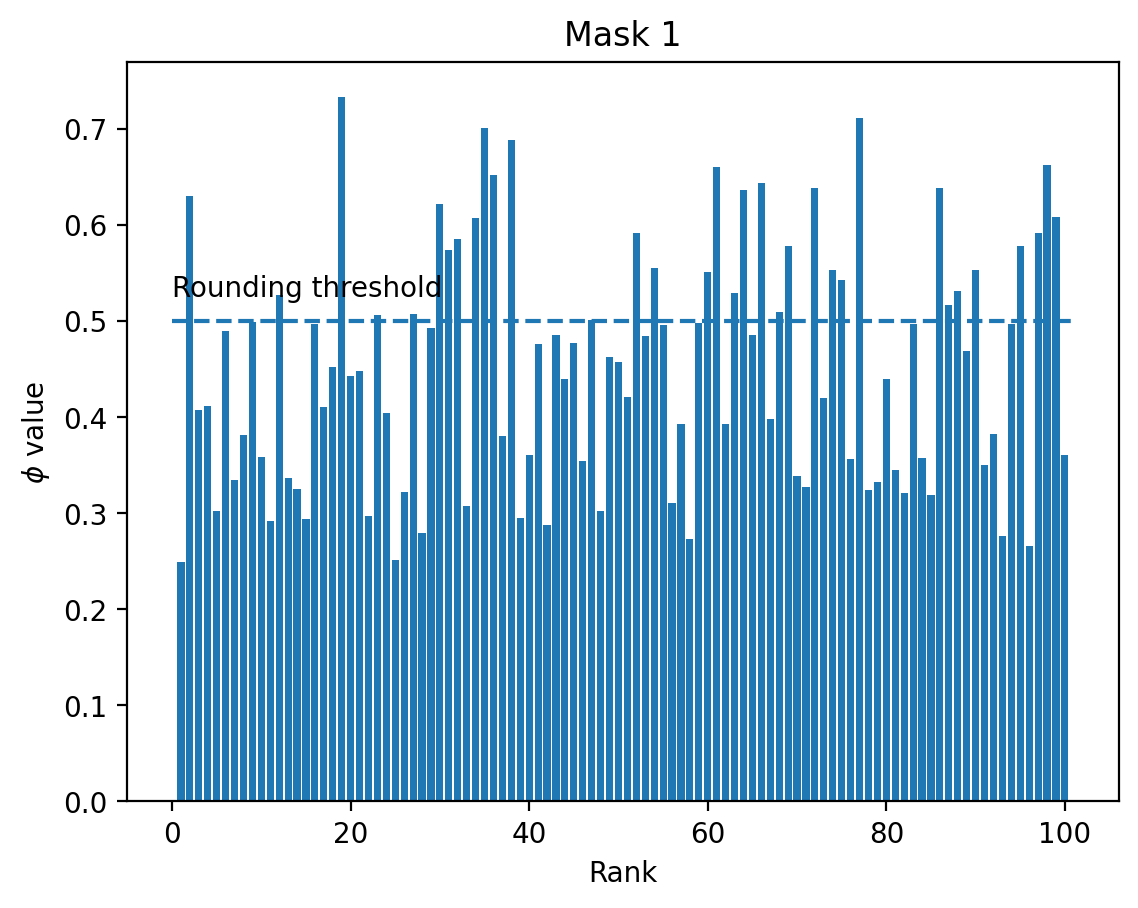

#nz ranks: 34/100

Compression:	9.110
Layer:  Factorized Linear: [512, 784] -> [512, 100]-[100, 784]


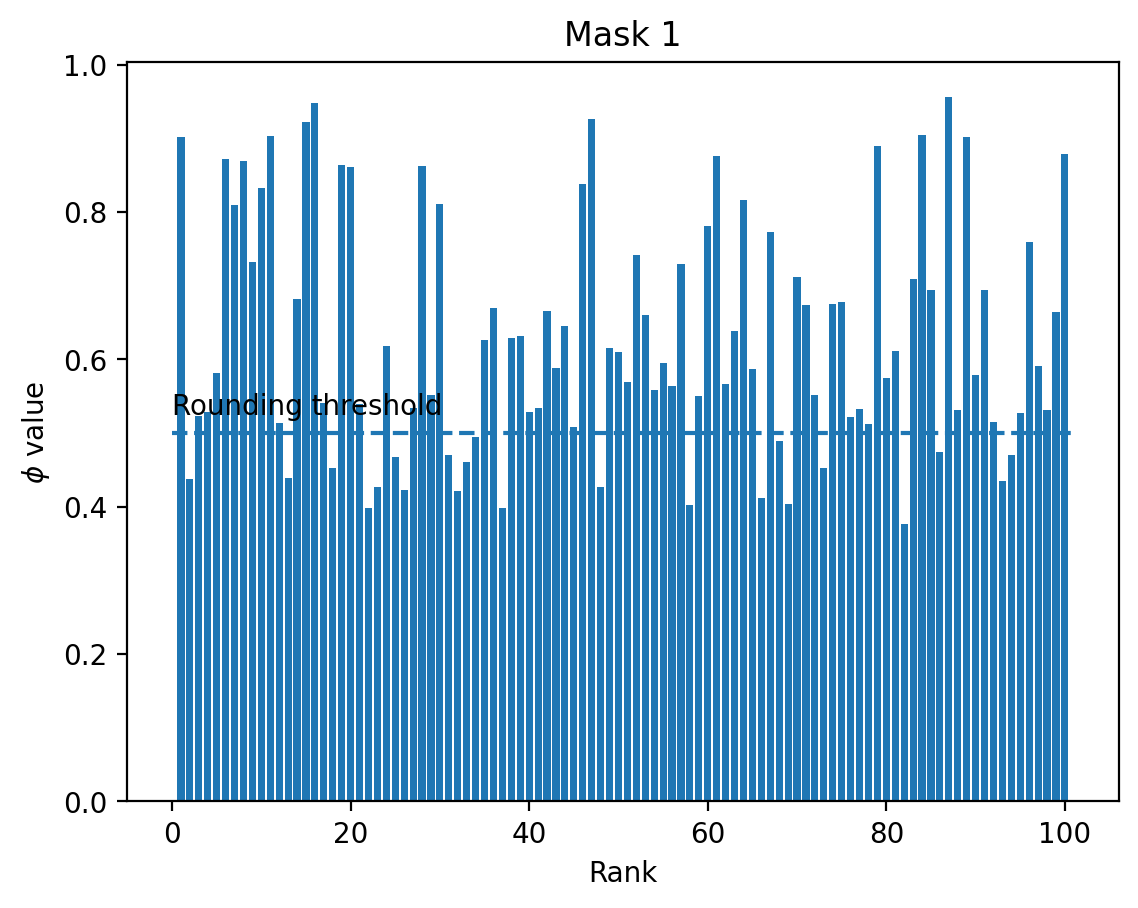

#nz ranks: 78/100

Compression:	3.971
Total compression:	5.383


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------




In [12]:
comps = []

for k, model in enumerate(models, 1):
    print(f"Model number {k}...")
    print()
    comps.append(get_comp_info(model))
    print()
    print()
    print(100*'-')
    print(100*'-')
    print(100*'-')
    print()
    print()

Let's plot the latent vector representations of a few batches of data.

In [31]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            # plt.savefig(f"images/FactorizedVAE-{mode}-latent")
            break

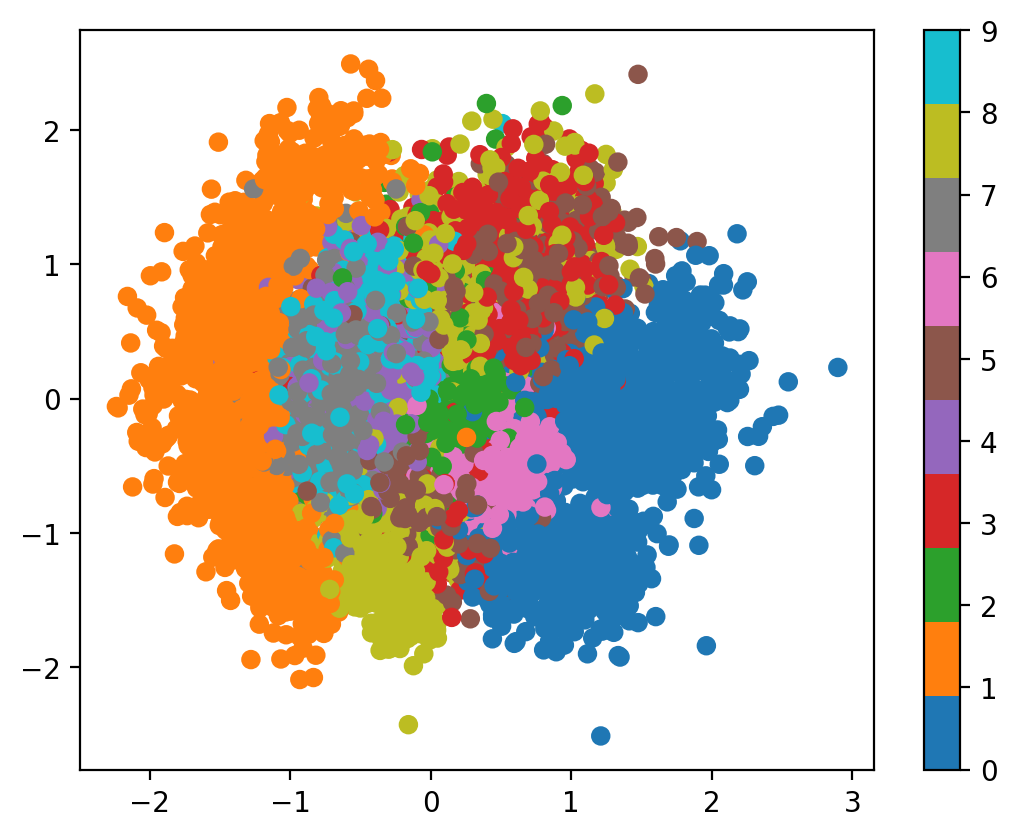

In [32]:
vae = models[0]

plot_latent(vae, data)

We can see that, compared to the traditional autoencoder, the range of values for latent vectors is much smaller, and more centralized. The distribution overall of $p(z \mid x)$ appears to be much closer to a Gaussian distribution.

Let's also look at the reconstructed digits from the latent space:

In [29]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    # plt.savefig(f"images/FactorizedVAE-{mode}-reconstructed")

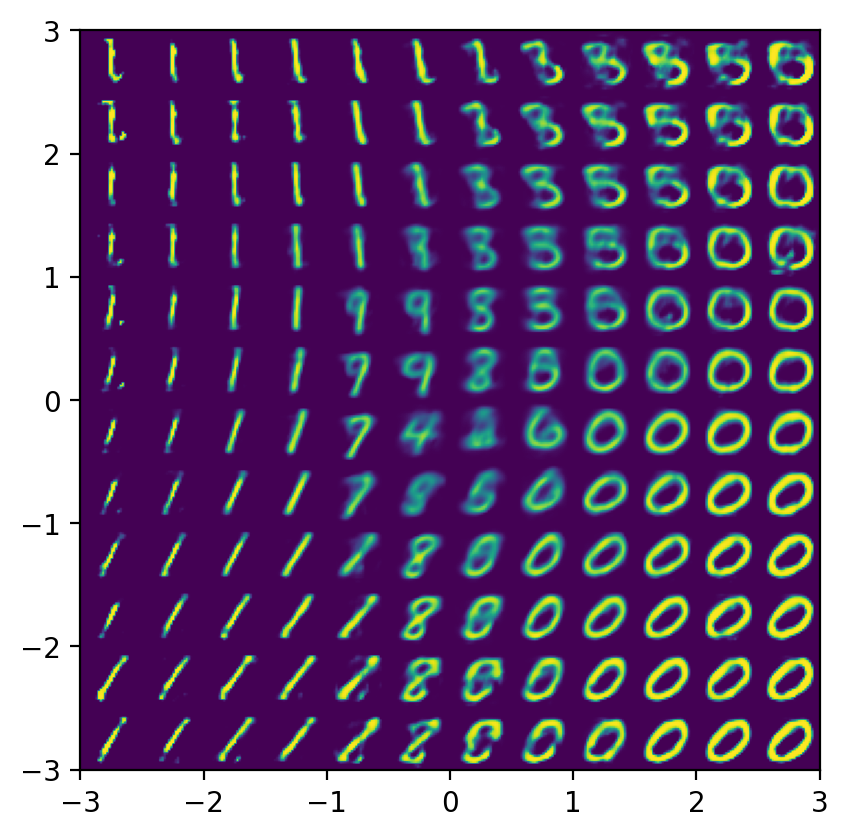

In [30]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

# Conclusions

Variational autoencoders produce a latent space $Z$ that is more compact and smooth than that learned by traditional autoencoders. This lets us randomly sample points $z \sim Z$ and produce corresponding reconstructions $\hat{x} = d(z)$ that form realistic digits, unlike traditional autoencoders.

# Extra Fun

One final thing that I wanted to try out was **interpolation**. Given two inputs $x_1$ and $x_2$, and their corresponding latent vectors $z_1$ and $z_2$, we can interpolate between them by decoding latent vectors between $x_1$ and $x_2$. 

The following code produces a row of images showing the interpolation between digits.

In [17]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [18]:
x, y = next(iter(data)) # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

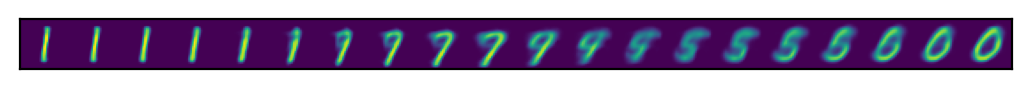

In [19]:
interpolate(vae, x_1, x_2, n=20)

I also wanted to write some code to generate a GIF of the transition, instead of just a row of images. The code below modifies the code above to produce a GIF.

In [20]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255
    
    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning
    
    images_list[0].save(
        f'{filename}.gif', 
        save_all=True, 
        append_images=images_list[1:],
        loop=1)

In [33]:
interpolate_gif(vae, f"images/factorized-vae-{mode}", x_1, x_2)

<img src='mars-vae.gif'>

## Time

In [35]:
batch = next(iter(data))[0]

In [36]:
%timeit vae(batch)

675 µs ± 12 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
